In [1]:
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter, GalLinear, Fourier
from torchdyn.datasets import *
from torchdyn.utils import *

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import torch

import xarray as xr

In [2]:
ft = xr.open_dataset('dataset_T_2023_1000hPa.nc')


t100 = ft.variables['t'][:,:,:] # T at 100m height
t100_data = np.array(t100)

c:\Users\Anwender\.conda\envs\rivapy\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


In [3]:
fgp = xr.open_dataset('dataset_GP_2023_1000hPa.nc')


z100 = fgp.variables['z'][:,:,:] # T at 100m height
z100_data = np.array(z100)

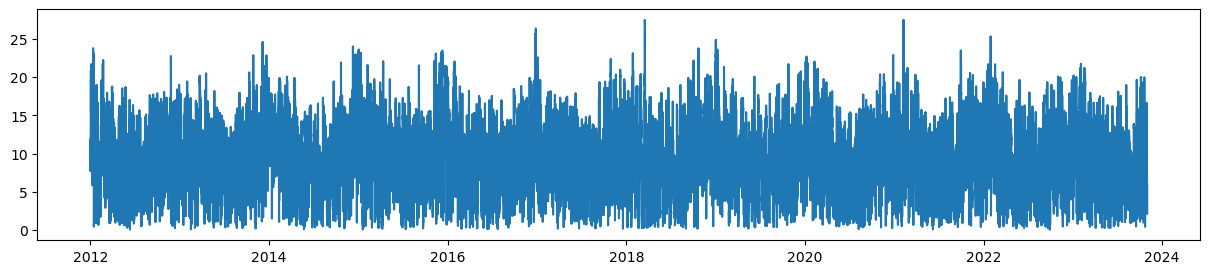

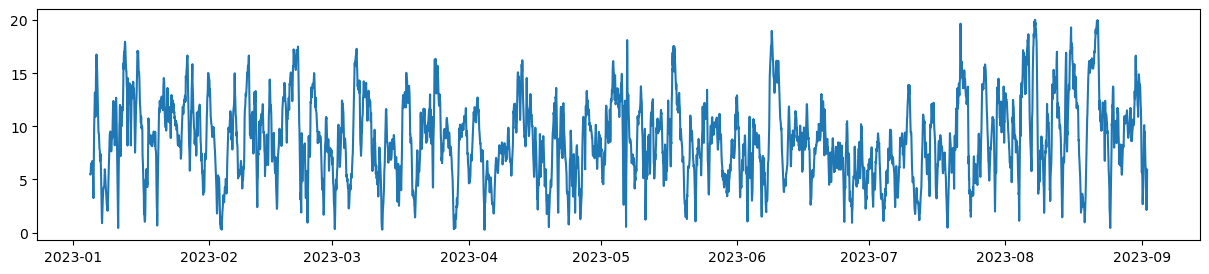

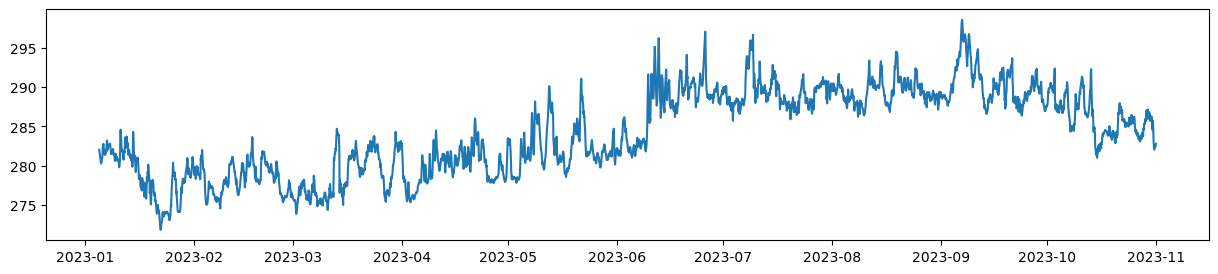

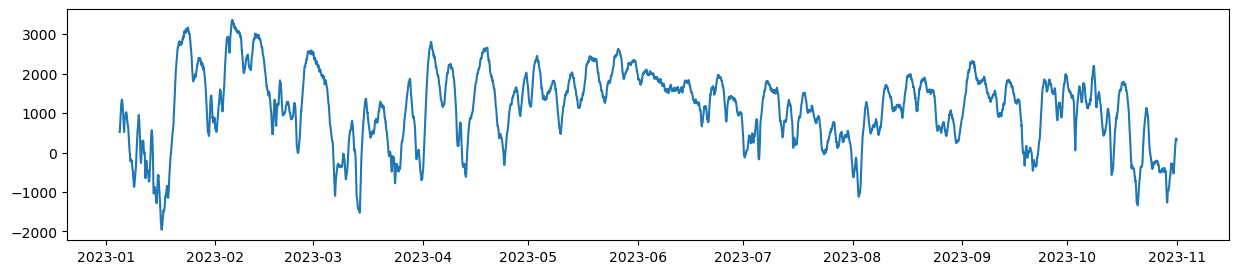

In [4]:
f = xr.open_dataset('dataset_2012-2023_1000hPa.nc')



lons = f.variables['longitude'][:]  # longitude
lats = f.variables['latitude'][:]  # latitude
u100 = f.variables['u'][:,:,:,0] # u-wind at 100m height
v100 = f.variables['v'][:,:,:,0]  # v-wind at 100m height
time = f.variables['time'][:]


ws100_data = np.array(np.sqrt(u100*u100+v100*v100))


nan_idx = np.argwhere(~np.isnan(ws100_data[:,0,0])).T[0]
ws100 = ws100_data[nan_idx,:,:]
time_vec = time[nan_idx]

plt.figure(figsize = (15,3))
plt.plot(time_vec, ws100[:,2,2])

plt.figure(figsize = (15,3))
plt.plot(time_vec[-24*300:],ws100_data[-24*300:,2,2])

plt.figure(figsize = (15,3))
plt.plot(time_vec[-24*300:],t100_data[-24*300:,2,2])

plt.figure(figsize = (15,3))
plt.plot(time_vec[-24*300:],z100_data[-24*300:,2,2])


#print(time_vec[-1],ws100[-1,2,2])




(array([  37.,  137.,  376.,  656.,  943., 1390., 1794., 1178.,  499.,
         190.]),
 array([-1956.40820312, -1424.38342285,  -892.35852051,  -360.33370972,
          171.69111633,   703.71594238,  1235.74072266,  1767.765625  ,
         2299.79052734,  2831.81518555,  3363.84008789]),
 <BarContainer object of 10 artists>)

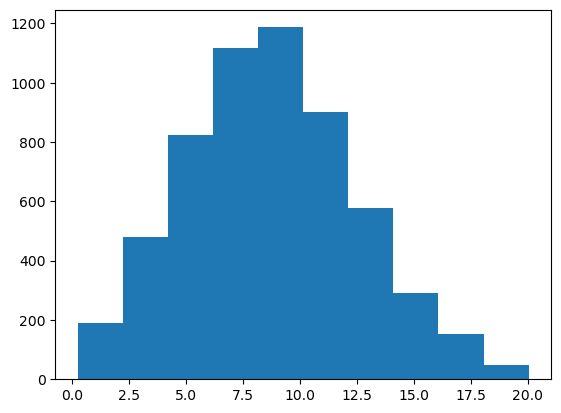

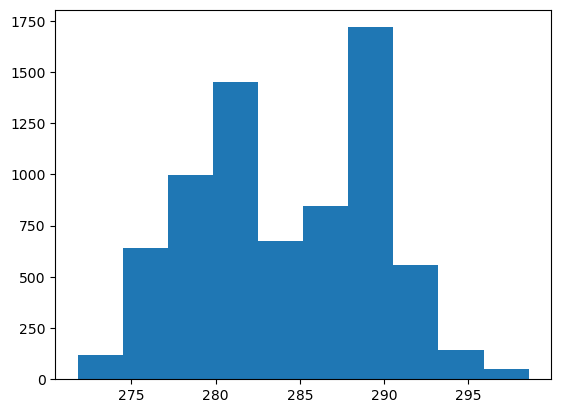

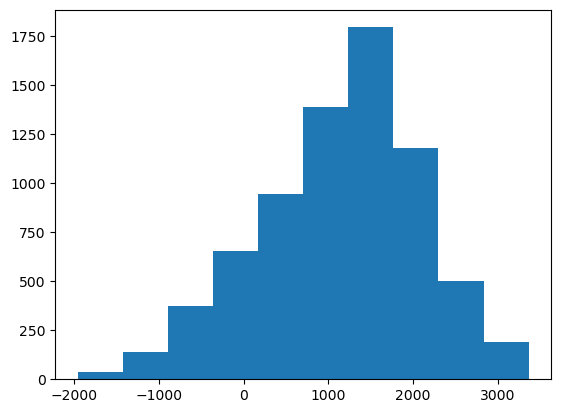

In [5]:
plt.figure()
plt.hist(ws100_data[-24*300:,2,2])

plt.figure()
plt.hist(t100_data[-24*300:,2,2])

plt.figure()
plt.hist(z100_data[-24*300:,2,2])

# running average data from 2023


In [6]:
ws_ly = ws100[-24*301:,:,:]
t_ly = t100_data[-24*301:,:,:]
z_ly = z100_data[-24*301:,:,:]

window_size = 24
# Initialize an empty list to store moving averages
ws_ma = ws_ly.copy()
t_ma = t_ly.copy()
z_ma = z_ly.copy()

 
# Loop through the array t o
#consider every window of size 3
for j in range(33):
    print(j)
    for k in range(37):
        i = 0
        while i < len(ws_ly) - window_size + 1:
 
            window_average = round(np.sum(ws_ly[i:i+window_size,j,k]) / window_size, 2)
            ws_ma[i,j,k] = window_average
            #ws_ma[i,j,k] = (ws_ma[i,j,k] - ws_mean)/ws_std

            window_average = round(np.sum(t_ly[i:i+window_size,j,k]) / window_size, 2)
            t_ma[i,j,k] = window_average
            #t_ma[i,j,k] = (t_ma[i,j,k] - t_mean)/t_std

            window_average = round(np.sum(z_ly[i:i+window_size,j,k]) / window_size, 2)
            z_ma[i,j,k] = window_average
            #z_ma[i,j,k] = (z_ma[i,j,k] - z_mean)/z_std

            i += 1


ws_mean = np.mean(ws_ma[0,:,:])
ws_std = np.std(ws_ma[0,:,:])
t_mean = np.mean(t_ma[0,:,:])
t_std = np.std(t_ma[0,:,:])
z_mean = np.mean(z_ma[0,:,:])
z_std = np.std(z_ma[0,:,:])

ws_ma = (ws_ma-ws_mean)/ws_std
t_ma = (t_ma-t_mean)/t_std
z_ma = (z_ma-z_mean)/z_std
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


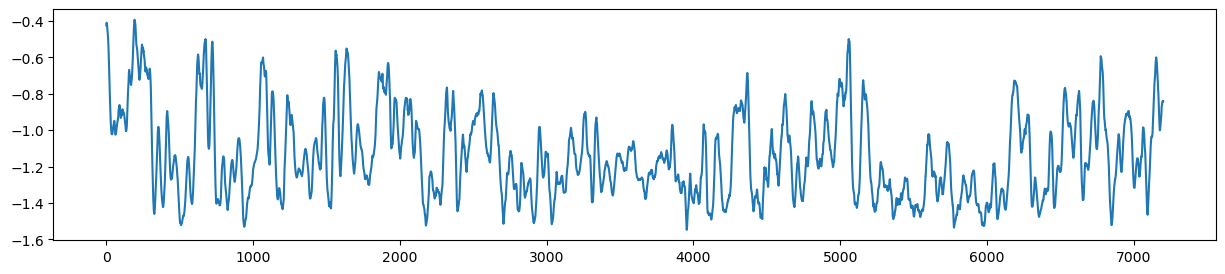

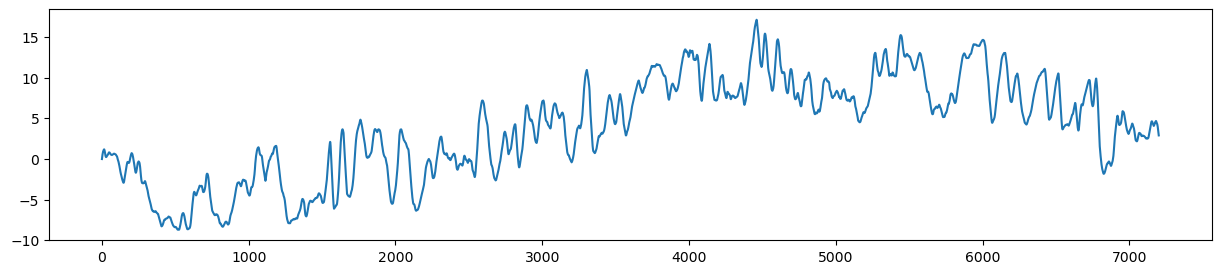

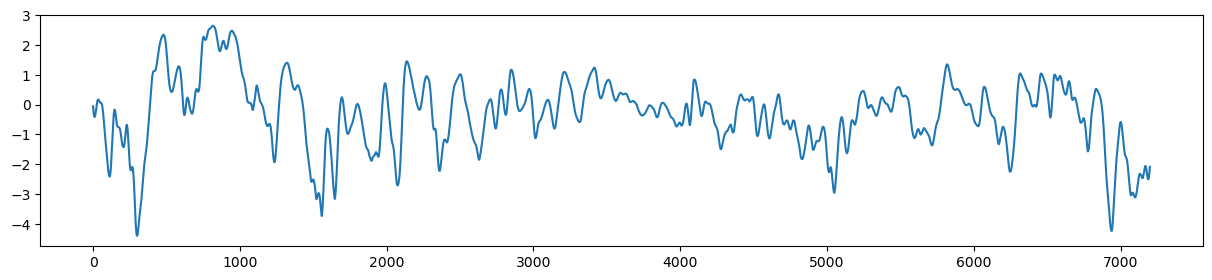

In [7]:
plt.figure(figsize = (15,3))
#plt.plot(ws_ly[:,15,15])
plt.plot(ws_ma[:len(ws_ly) - window_size + 1,15,15])

plt.figure(figsize = (15,3))
#plt.plot(t_ly[:,15,15])
plt.plot(t_ma[:len(ws_ly) - window_size + 1,15,15])


plt.figure(figsize = (15,3))
#plt.plot(t_ly[:,15,15])
plt.plot(z_ma[:len(z_ly) - window_size + 1,15,15])

# Deseasonalize and normalize data from 2023

In [18]:
ws_ly = ws100[-24*301:,:,:]
t_ly = t100_data[-24*301:,:,:]
z_ly = z100_data[-24*301:,:,:]
time_ly = time_vec[-24*301:]
# deseasonalization
for xx in range(33):
    print(xx)
    for yy in range(37):
        mu_ws = []
        mu_t = []
        #mu_z = []
        for i in range(0,24):
            mu_ws.append(0)
            mu_t.append(0)
            #mu_z.append(0)
            count = 0
            for j in range(i,len(time_ly)-24,24):
                mu_ws[i] = mu_ws[i] + ws_ly[j,xx,yy]
                mu_t[i] = mu_t[i] + t_ly[j,xx,yy]
                #mu_z[i] = mu_z[i] + z_ly[j,xx,yy]
                count = count + 1

            mu_ws[i] = mu_ws[i]/count
            mu_t[i] = mu_t[i]/count
            #mu_z[i] = mu_z[i]/count


        sigma_ws = []
        sigma_t = []
        #sigma_z = []
        for i in range(0,24):
            sigma_ws.append(0)
            sigma_t.append(0)
            #sigma_z.append(0)
            count = 0
            for j in range(i,len(time_ly)-24,24):
                sigma_ws[i] = sigma_ws[i] + (ws_ly[j,xx,yy] - mu_ws[i])**2
                sigma_t[i] = sigma_t[i] + (t_ly[j,xx,yy] - mu_t[i])**2
                #sigma_z[i] = sigma_z[i] + (z_ly[j,xx,yy] - mu_z[i])**2
                count = count + 1

            sigma_ws[i] = np.sqrt(sigma_ws[i]/count)
            sigma_t[i] = np.sqrt(sigma_t[i]/count)
            #sigma_z[i] = np.sqrt(sigma_z[i]/count)

        for i in range(0,24):
            for j in range(i,len(time_ly)-24,24):
                ws_ly[j,xx,yy] = (ws_ly[j,xx,yy] - mu_ws[i])/sigma_ws[i]
                t_ly[j,xx,yy] = (t_ly[j,xx,yy] - mu_t[i])/sigma_t[i]
                #z_ly[j,xx,yy] = (z_ly[j,xx,yy] - mu_z[i])/sigma_z[i]
#box cox transformation (transform data to normal distribution)
from scipy.special import boxcox, inv_boxcox
import scipy.stats as s
x_trans = s.yeojohnson(ws_ly,0.5)

#z_ly = (z_ly - np.mean(z_ly))/np.std(z_ly)







0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [442]:
z_ly = (z100_data[-24*301:,:,:]-np.mean(z100_data[-24*301:,:,:]))/1000.

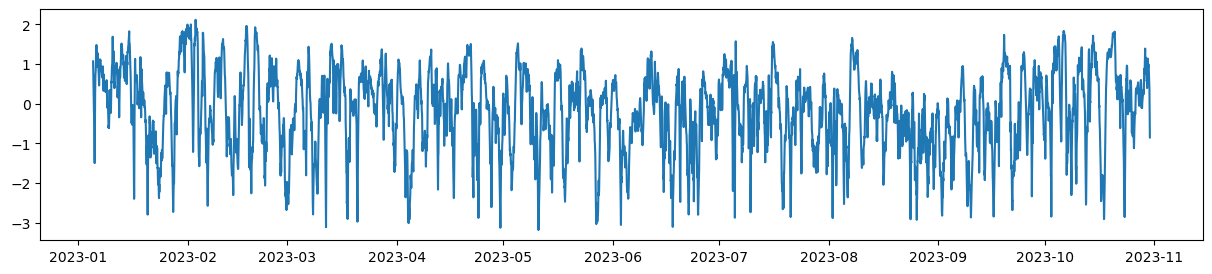

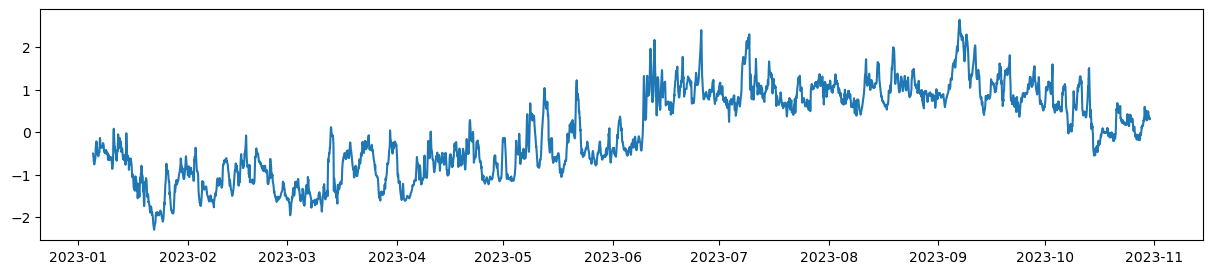

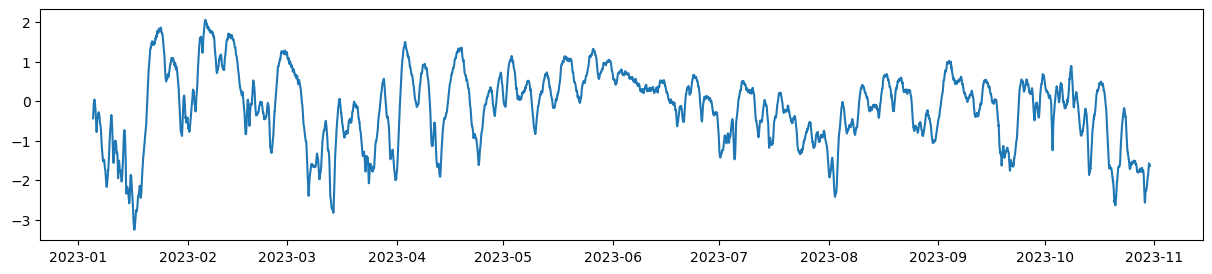

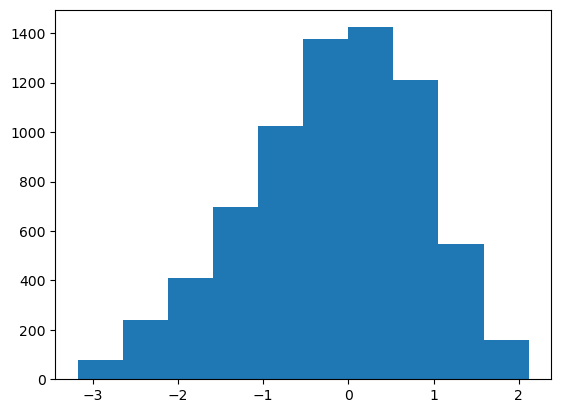

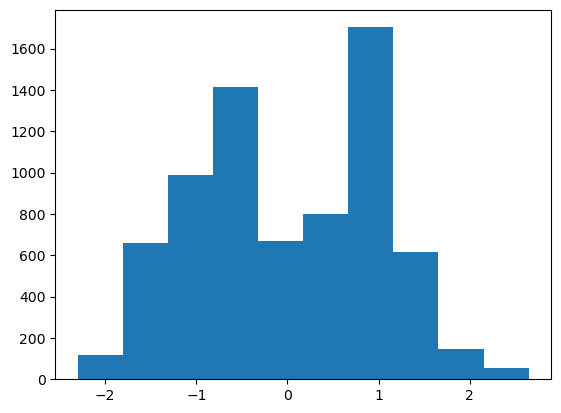

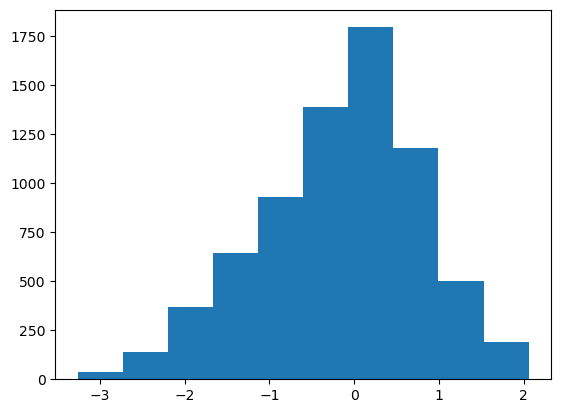

In [443]:
plt.figure(figsize = (15,3))
plt.plot(time_ly[30:-30], x_trans[30:-30,2,2])

plt.figure(figsize = (15,3))
plt.plot(time_ly[30:-30], t_ly[30:-30,2,2])

plt.figure(figsize = (15,3))
plt.plot(time_ly[30:-30], z_ly[30:-30,2,2])

plt.figure()
plt.hist(x_trans[30:-30,2,2])

plt.figure()
plt.hist(t_ly[30:-30,2,2])

plt.figure()
plt.hist(z_ly[30:-30,2,2])


ws_array = x_trans[30:-30,:,:]
temp_array = t_ly[30:-30,:,:]
gp_array = z_ly[30:-30,:,:]


# Neural SDEs as Infinite-Dimensional GANs for wind speed time series in Germany

In [1150]:
dataset_size = 32+37
time_size = 64
ys_ = np.zeros((dataset_size,time_size,2))
ts_ = np.arange(0,time_size)


print(ts_)

for i in range(33):
    for j in range(37):
        for t in range(time_size):
            ys_[i+j,t,0] = ts_[t]
            ys_[i+j,t,1] = x_trans[t-time_size-90,i,j]

#normalization 
y0 = ys_[:,0,1]
ys_[:,:,1] = (ys_[:,:,1] - np.mean(y0))/np.std(y0)



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
-3.94209624685744e-17


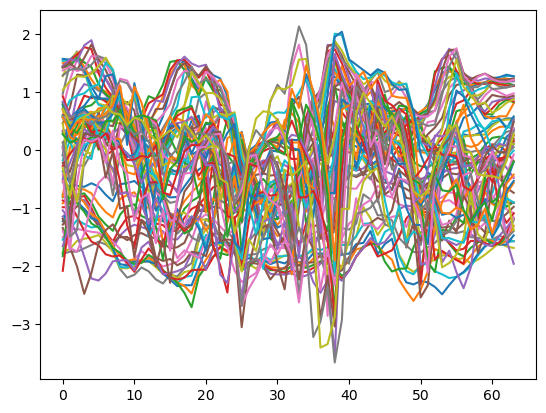

In [1135]:
for i in range(dataset_size):
    plt.plot(ys_[i,:,1])



506.6427244347171


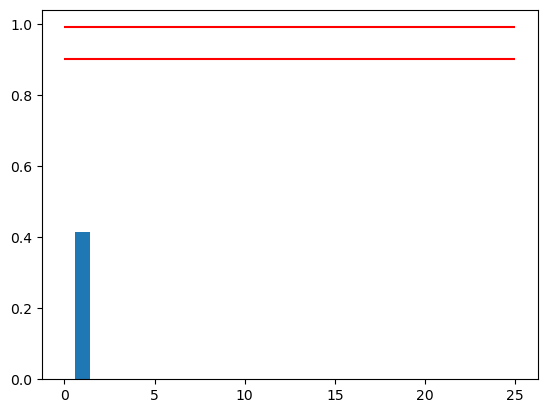

KeyboardInterrupt: 

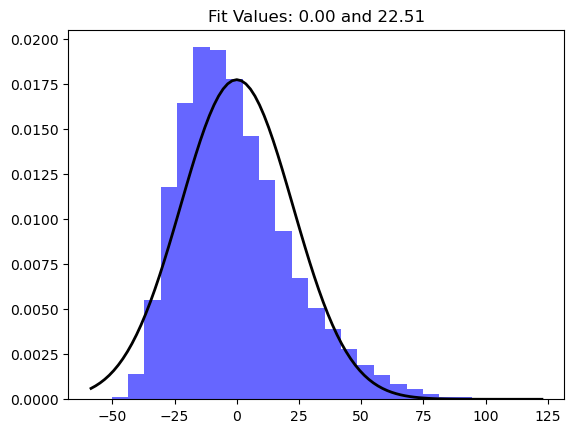

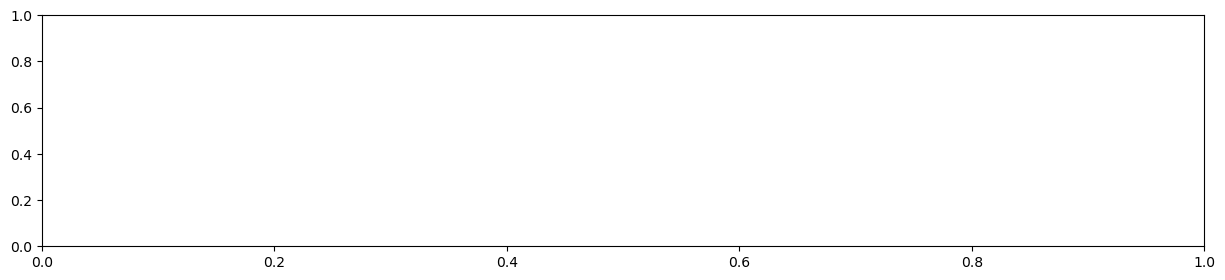

In [247]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.stats import norm 


nPCAc = 1
ws100[np.isnan(ws100)] = 0
Y = ws100[:,:,:]
X = Y.reshape(Y.shape[0], -1)
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)
pca = PCA(n_components=nPCAc)
principalComponents_ERA5 = pca.fit_transform(X)

bla = principalComponents_ERA5[:150000,0]
for j in range(1,nPCAc):
    bla = np.vstack([bla, principalComponents_ERA5[:150000,j]])       
sigq = np.cov(bla)

print(sigq)


plt.figure(1)
plt.bar(np.linspace(1,pca.n_components_,pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y = 0.9,xmin= 0, xmax = 25,colors="red")
plt.hlines(y = 0.99,xmin= 0, xmax = 25,colors="red")
plt.show()

for i in range(nPCAc):

    #plt.figure(i+2, figsize=[15,3])
    #plt.plot(principalComponents_ERA5[:150000,i])

    mu, std = norm.fit(principalComponents_ERA5[:150000,i]) 
    plt.figure(i+2)
    plt.hist(principalComponents_ERA5[:150000,i], bins=25, density=True, alpha=0.6, color='b') 
    xmin, xmax = plt.xlim() 
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, mu, std) 
  
    plt.plot(x, p, 'k', linewidth=2) 
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
    plt.title(title) 

plt.figure(figsize=[15,3])
plt.plot(time_vec,principalComponents_ERA5[:150000,0])

In [1136]:


import fire
import matplotlib.pyplot as plt
import torch
import torch.optim.swa_utils as swa_utils
import torchcde
import torchsde
import tqdm


###################
# First some standard helper objects.
###################

class LipSwish(torch.nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)


class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()

        model = [torch.nn.Linear(in_size, mlp_size),
                 LipSwish()]
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            ###################
            # LipSwish activations are useful to constrain the Lipschitz constant of the discriminator.
            # (For simplicity we additionally use them in the generator, but that's less important.)
            ###################
            model.append(LipSwish())
        model.append(torch.nn.Linear(mlp_size, out_size))
        if tanh:
            model.append(torch.nn.Tanh())
        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)


###################
# Now we define the SDEs.
#
# We begin by defining the generator SDE.
###################
class GeneratorFunc(torch.nn.Module):
    sde_type = 'stratonovich'
    noise_type = 'general'

    def __init__(self, noise_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._noise_size = noise_size
        self._hidden_size = hidden_size

        ###################
        # Drift and diffusion are MLPs. They happen to be the same size.
        # Note the final tanh nonlinearity: this is typically important for good performance, to constrain the rate of
        # change of the hidden state.
        # If you have problems with very high drift/diffusions then consider scaling these so that they squash to e.g.
        # [-3, 3] rather than [-1, 1].
        ###################
        self._drift = MLP(1 + hidden_size, hidden_size, mlp_size, num_layers, tanh=True)
        self._diffusion = MLP(1 + hidden_size, hidden_size * noise_size, mlp_size, num_layers, tanh=True)

    def f_and_g(self, t, x):
        # t has shape ()
        # x has shape (batch_size, hidden_size)
        t = t.expand(x.size(0), 1)
        tx = torch.cat([t, x], dim=1)
        return self._drift(tx), self._diffusion(tx).view(x.size(0), self._hidden_size, self._noise_size)


###################
# Now we wrap it up into something that computes the SDE.
###################
class Generator(torch.nn.Module):
    def __init__(self, data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._initial_noise_size = initial_noise_size
        self._hidden_size = hidden_size

        self._initial = MLP(initial_noise_size, hidden_size, mlp_size, num_layers, tanh=False)
        self._func = GeneratorFunc(noise_size, hidden_size, mlp_size, num_layers)
        self._readout = torch.nn.Linear(hidden_size, data_size)

    def forward(self, ts, batch_size):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.

        ###################
        # Actually solve the SDE.
        ###################
        init_noise = torch.randn(batch_size, self._initial_noise_size, device=ts.device)
        x0 = self._initial(init_noise)

        ###################
        # We use the reversible Heun method to get accurate gradients whilst using the adjoint method.
        ###################
        xs = torchsde.sdeint_adjoint(self._func, x0, ts, method='reversible_heun', dt=1.0,
                                     adjoint_method='adjoint_reversible_heun',)
        xs = xs.transpose(0, 1)
        ys = self._readout(xs)

        ###################
        # Normalise the data to the form that the discriminator expects, in particular including time as a channel.
        ###################
        ts = ts.unsqueeze(0).unsqueeze(-1).expand(batch_size, ts.size(0), 1)
        return torchcde.linear_interpolation_coeffs(torch.cat([ts, ys], dim=2))


###################
# Next the discriminator. Here, we're going to use a neural controlled differential equation (neural CDE) as the
# discriminator, just as in the "Neural SDEs as Infinite-Dimensional GANs" paper. (You could use other things as well,
# but this is a natural choice.)
#
# There's actually a few different (roughly equivalent) ways of making the discriminator work. The curious reader is
# encouraged to have a read of the comment at the bottom of this file for an in-depth explanation.
###################
class DiscriminatorFunc(torch.nn.Module):
    def __init__(self, data_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._data_size = data_size
        self._hidden_size = hidden_size

        # tanh is important for model performance
        self._module = MLP(1 + hidden_size, hidden_size * (1 + data_size), mlp_size, num_layers, tanh=True)

    def forward(self, t, h):
        # t has shape ()
        # h has shape (batch_size, hidden_size)
        t = t.expand(h.size(0), 1)
        th = torch.cat([t, h], dim=1)
        return self._module(th).view(h.size(0), self._hidden_size, 1 + self._data_size)


class Discriminator(torch.nn.Module):
    def __init__(self, data_size, hidden_size, mlp_size, num_layers):
        super().__init__()

        self._initial = MLP(1 + data_size, hidden_size, mlp_size, num_layers, tanh=False)
        self._func = DiscriminatorFunc(data_size, hidden_size, mlp_size, num_layers)
        self._readout = torch.nn.Linear(hidden_size, 1)

    def forward(self, ys_coeffs):
        # ys_coeffs has shape (batch_size, t_size, 1 + data_size)
        # The +1 corresponds to time. When solving CDEs, It turns out to be most natural to treat time as just another
        # channel: in particular this makes handling irregular data quite easy, when the times may be different between
        # different samples in the batch.

        Y = torchcde.LinearInterpolation(ys_coeffs)
        Y0 = Y.evaluate(Y.interval[0])
        h0 = self._initial(Y0)
        hs = torchcde.cdeint(Y, self._func, h0, Y.interval, method='reversible_heun', backend='torchsde', dt=1.0,
                             adjoint_method='adjoint_reversible_heun',
                             adjoint_params=(ys_coeffs,) + tuple(self._func.parameters()))
        score = self._readout(hs[:, -1])
        return score.mean()


###################
# Generate some data. For this example we generate some synthetic data from a time-dependent Ornstein-Uhlenbeck SDE.
###################
def get_data(batch_size, device):
    dataset_size = 32+37
    t_size = 64

    class OrnsteinUhlenbeckSDE(torch.nn.Module):
        sde_type = 'ito'
        noise_type = 'scalar'

        def __init__(self, mu, theta, sigma):
            super().__init__()
            self.register_buffer('mu', torch.as_tensor(mu))
            self.register_buffer('theta', torch.as_tensor(theta))
            self.register_buffer('sigma', torch.as_tensor(sigma))

        def f(self, t, y):
            return self.mu * t - self.theta * y

        def g(self, t, y):
            return self.sigma.expand(y.size(0), 1, 1) * (2 * t / t_size)

    ou_sde = OrnsteinUhlenbeckSDE(mu=0.02, theta=0.1, sigma=0.4).to(device)
    y0 = torch.rand(dataset_size, device=device).unsqueeze(-1) * 2 - 1
    ts = torch.linspace(0, t_size - 1, t_size, device=device)
    ys = torchsde.sdeint(ou_sde, y0, ts, dt=1.)

    ###################
    # To demonstrate how to handle irregular data, then here we additionally drop some of the data (by setting it to
    # NaN.)
    ###################
    ys_num = ys.numel()
    to_drop = torch.randperm(ys_num)[:int(0.3 * ys_num)]
    ys.view(-1)[to_drop] = float('nan')

    ###################
    # Typically important to normalise data. Note that the data is normalised with respect to the statistics of the
    # initial data, _not_ the whole time series. This seems to help the learning process, presumably because if the
    # initial condition is wrong then it's pretty hard to learn the rest of the SDE correctly.
    ###################
    y0_flat = ys[0].view(-1)
    y0_not_nan = y0_flat.masked_select(~torch.isnan(y0_flat))
    ys = (ys - y0_not_nan.mean()) / y0_not_nan.std()

    ###################
    # As discussed, time must be included as a channel for the discriminator.
    ###################
    ys = torch.cat([ts.unsqueeze(0).unsqueeze(-1).expand(dataset_size, t_size, 1),
                    ys.transpose(0, 1)], dim=2)
    # shape (dataset_size=1000, t_size=100, 1 + data_size=3)
    

    return ts, ys


###################
# We'll plot some results at the end.
###################
def plot(ts, generator, dataloader, num_plot_samples, plot_locs):
    # Get samples
    real_samples, = next(iter(dataloader))
    assert num_plot_samples <= real_samples.size(0)
    real_samples = torchcde.LinearInterpolation(real_samples).evaluate(ts)
    real_samples = real_samples[..., 1]

    with torch.no_grad():
        generated_samples = generator(ts, real_samples.size(0)).cpu()
    generated_samples = torchcde.LinearInterpolation(generated_samples).evaluate(ts)
    generated_samples = generated_samples[..., 1]

    # Plot histograms
    for prop in plot_locs:
        time = int(prop * (real_samples.size(1) - 1))
        real_samples_time = real_samples[:, time]
        generated_samples_time = generated_samples[:, time]
        _, bins, _ = plt.hist(real_samples_time.cpu().numpy(), bins=32, alpha=0.7, label='Real', color='dodgerblue',
                              density=True)
        bin_width = bins[1] - bins[0]
        num_bins = int((generated_samples_time.max() - generated_samples_time.min()).item() // bin_width)
        plt.hist(generated_samples_time.cpu().numpy(), bins=num_bins, alpha=0.7, label='Generated', color='crimson',
                 density=True)
        plt.legend()
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title(f'Marginal distribution at time {time}.')
        plt.tight_layout()
        plt.show()

    real_samples = real_samples[:num_plot_samples]
    generated_samples = generated_samples[:num_plot_samples]

    # Plot samples
    real_first = True
    generated_first = True
    for real_sample_ in real_samples:
        kwargs = {'label': 'Real'} if real_first else {}
        plt.plot(ts.cpu(), real_sample_.cpu(), color='dodgerblue', linewidth=0.5, alpha=0.7, **kwargs)
        real_first = False
    for generated_sample_ in generated_samples:
        kwargs = {'label': 'Generated'} if generated_first else {}
        plt.plot(ts.cpu(), generated_sample_.cpu(), color='crimson', linewidth=0.5, alpha=0.7, **kwargs)
        generated_first = False
    plt.legend()
    plt.title(f"{num_plot_samples} samples from both real and generated distributions.")
    plt.tight_layout()
    plt.show()


###################
# Now do normal GAN training, and plot the results.
#
# GANs are famously tricky and SDEs trained as GANs are no exception. Hopefully you can learn from our experience and
# get these working faster than we did -- we found that several tricks were often helpful to get this working in a
# reasonable fashion:
# - Stochastic weight averaging (average out the oscillations in GAN training).
# - Weight decay (reduce the oscillations in GAN training).
# - Final tanh nonlinearities in the architectures of the vector fields, as above. (To avoid the model blowing up.)
# - Adadelta (interestingly seems to be a lot better than either SGD or Adam).
# - Choosing a good learning rate (always important).
# - Scaling the weights at initialisation to be roughly the right size (chosen through empirical trial-and-error).
###################

def evaluate_loss(ts, batch_size, dataloader, generator, discriminator):
    with torch.no_grad():
        total_samples = 0
        total_loss = 0
        for real_samples, in dataloader:
            generated_samples = generator(ts, batch_size)
            generated_score = discriminator(generated_samples)
            real_score = discriminator(real_samples)
            loss = generated_score - real_score
            total_samples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_samples


In [1137]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [1138]:
initial_noise_size=1#5    # How many noise dimensions to sample at the start of the SDE.
noise_size=3          # How many dimensions the Brownian motion has.
hidden_size=32#16        # How big the hidden size of the generator SDE and the discriminator CDE are.
mlp_size=16           # How big the layers in the various MLPs are.
num_layers=1          # How many hidden layers to have in the various MLPs.

# Training hyperparameters. Be prepared to tune these very carefully, as with any GAN.
generator_lr=2e-4      # Learning rate often needs careful tuning to the problem.
discriminator_lr=1e-3  # Learning rate often needs careful tuning to the problem.
batch_size=1024        # Batch size.
steps=5000#10000            # How many steps to train both generator and discriminator for.
init_mult1=3           # Changing the initial parameter size can help.
init_mult2=0.5         #
weight_decay=0.01      # Weight decay.
swa_step_start=500#5000    # When to start using stochastic weight averaging.

# Evaluation and plotting hyperparameters
steps_per_print=10                   # How often to print the loss.
num_plot_samples=dataset_size#32+37                  # How many samples to use on the plots at the end.
plot_locs=(0.1, 0.3, 0.5, 0.7, 0.9)  # Plot some marginal distributions at this proportion of the way along.

In [1139]:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

In [1140]:
ts, ys = get_data(batch_size=batch_size, device=device)

In [1141]:
for i in range(0,1):
    for j in range(dataset_size):
        for t in range(time_size):
            ys[i+j,t,1] = ys_[i+j,t,1]

In [1142]:
#ts, data_size, train_dataloader = get_data(batch_size=batch_size, device=device)
ts = torch.tensor(ts_, device=device)
###################
# Package up.
###################
data_size = ys.size(-1) - 1  # How many channels the data has (not including time, hence the minus one).
ys_coeffs = torchcde.linear_interpolation_coeffs(ys)  # as per neural CDEs.
dataset = torch.utils.data.TensorDataset(ys_coeffs)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [1143]:
infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)
print(infinite_train_dataloader)

<generator object <genexpr> at 0x00000207CAB4AC80>


In [1144]:
generator = Generator(data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers).to(device)
discriminator = Discriminator(data_size, hidden_size, mlp_size, num_layers).to(device)
# Weight averaging really helps with GAN training.
averaged_generator = swa_utils.AveragedModel(generator)
averaged_discriminator = swa_utils.AveragedModel(discriminator)

In [1145]:
# Picking a good initialisation is important!
    # In this case these were picked by making the parameters for the t=0 part of the generator be roughly the right
    # size that the untrained t=0 distribution has a similar variance to the t=0 data distribution.
    # Then the func parameters were adjusted so that the t>0 distribution looked like it had about the right variance.
    # What we're doing here is very crude -- one can definitely imagine smarter ways of doing things.
    # (e.g. pretraining the t=0 distribution)
with torch.no_grad():
    for param in generator._initial.parameters():
        param *= init_mult1
    for param in generator._func.parameters():
        param *= init_mult2

In [1146]:
# Optimisers. Adadelta turns out to be a much better choice than SGD or Adam, interestingly.
generator_optimiser = torch.optim.Adadelta(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
discriminator_optimiser = torch.optim.Adadelta(discriminator.parameters(), lr=discriminator_lr,
                                                   weight_decay=weight_decay)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [1:41:24<00:00,  1.22s/it]


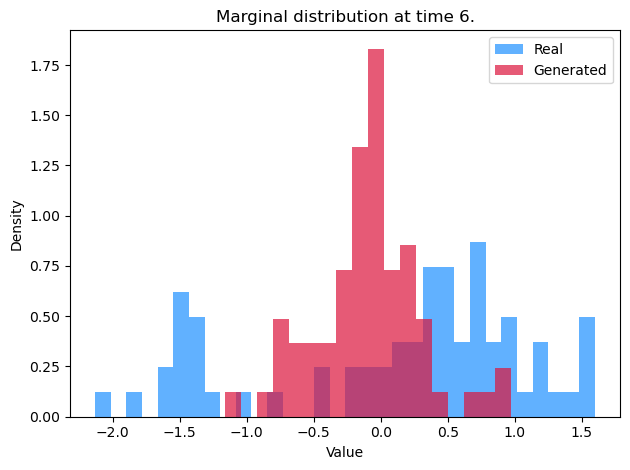

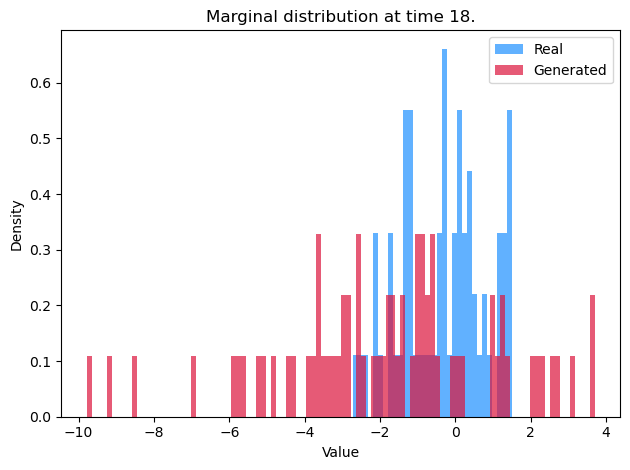

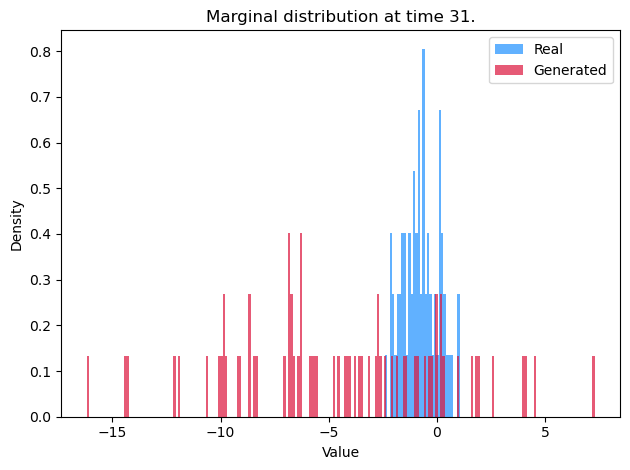

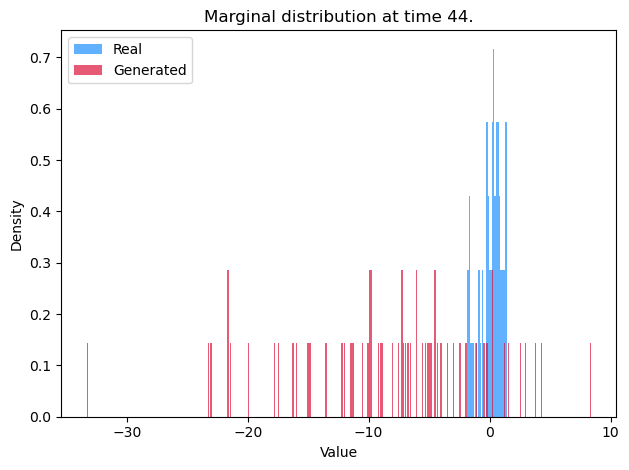

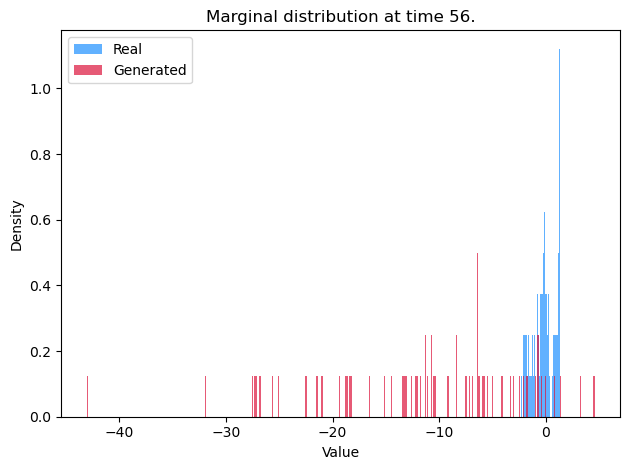

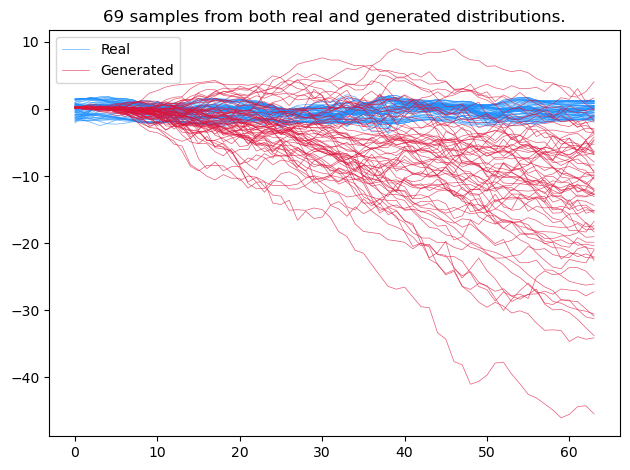

In [1147]:
# Train both generator and discriminator.
trange = tqdm.tqdm(range(steps))
for step in trange:
    real_samples, = next(infinite_train_dataloader)
    

    generated_samples = generator(ts, batch_size)
    generated_score = discriminator(generated_samples)
    
    real_score = discriminator(real_samples)
    loss = generated_score - real_score
    loss.backward()

    for param in generator.parameters():
        param.grad *= -1
    generator_optimiser.step()
    discriminator_optimiser.step()
    generator_optimiser.zero_grad()
    discriminator_optimiser.zero_grad()

    ###################
    # We constrain the Lipschitz constant of the discriminator using carefully-chosen clipping (and the use of
    # LipSwish activation functions).
    ###################
    with torch.no_grad():
        for module in discriminator.modules():
            if isinstance(module, torch.nn.Linear):
                lim = 1 / module.out_features
                module.weight.clamp_(-lim, lim)

    # Stochastic weight averaging typically improves performance.
    if step > swa_step_start:
        averaged_generator.update_parameters(generator)
        averaged_discriminator.update_parameters(discriminator)

        #if (step % steps_per_print) == 0 or step == steps - 1:
        #    total_unaveraged_loss = evaluate_loss(ts, batch_size, train_dataloader, generator, discriminator)
        #    if step > swa_step_start:
        #        total_averaged_loss = evaluate_loss(ts, batch_size, train_dataloader, averaged_generator.module,
        #                                            averaged_discriminator.module)
        #        trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f} "
        #                     f"Loss (averaged): {total_averaged_loss:.4f}")
        #    else:
        #        trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f}")
    generator.load_state_dict(averaged_generator.module.state_dict())
    discriminator.load_state_dict(averaged_discriminator.module.state_dict())

    #_, _, test_dataloader = get_data(batch_size=batch_size, device=device)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

plot(ts, generator, test_dataloader, num_plot_samples, plot_locs)

# latent SDE


In [19]:
x_sel = x_trans[-110:-110+32,15,15]

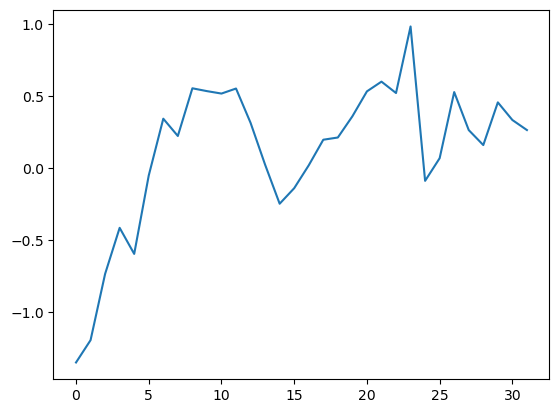

In [20]:
plt.plot(x_trans[-110:-110+32,15,15])

In [234]:
import scipy.stats as ss
XX = x_sel[:-1]
YY = x_sel[1:]
dt = 1.
res = ss.linregress(XX, YY)  # OLS
alpha = res.intercept
beta = res.slope
kappa_ols = -np.log(beta) / dt
theta_ols = alpha / (1 - beta)
res = YY - beta * XX - alpha  # residuals
std_resid = np.std(res, ddof=2)
sig_ols = std_resid * np.sqrt(2 * kappa_ols / (1 - beta**2))

print("OLS mu = ", theta_ols)
print("OLS theta = ", kappa_ols)
print("OLS sigma = ", sig_ols)

OLS mu =  0.2744866780889831
OLS theta =  0.3804342076678057
OLS sigma =  0.32196349509420025


In [21]:
"""Latent SDE fit to a single time series with uncertainty quantification."""
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim

import torchsde

In [22]:
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val


class EMAMetric(object):
    def __init__(self, gamma: Optional[float] = .99):
        super(EMAMetric, self).__init__()
        self._val = 0.
        self._gamma = gamma

    def step(self, x: Union[torch.Tensor, np.ndarray]):
        x = x.detach().cpu().numpy() if torch.is_tensor(x) else x
        self._val = self._gamma * self._val + (1 - self._gamma) * x
        return self._val

    @property
    def val(self):
        return self._val


def str2bool(v):
    """Used for boolean arguments in argparse; avoiding `store_true` and `store_false`."""
    if isinstance(v, bool): return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'): return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'): return False
    else: raise argparse.ArgumentTypeError('Boolean value expected.')


def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def _stable_division(a, b, epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon) * b.sign())
    return a / b

In [32]:
class LatentSDE(torchsde.SDEIto):

    def __init__(self, theta=1., mu=0., sigma=0.5):
        super(LatentSDE, self).__init__(noise_type="diagonal")
        logvar = math.log(sigma ** 2 / (2. * theta))

        # Prior drift.
        self.register_buffer("theta", torch.tensor([[theta]]))
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))

        # p(y0).
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        self.register_buffer("py0_logvar", torch.tensor([[logvar]]))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net = nn.Sequential(
            nn.Linear(3, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 1)
        )
        # Initialization trick from Glow.
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)

        # q(y0).
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)

    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            t = torch.full_like(y, fill_value=t)
        # Positional encoding in transformers for time-inhomogeneous posterior.
        return self.net(torch.cat((torch.sin(t), torch.cos(t), y), dim=-1))

    def g(self, t, y):  # Shared diffusion.
        return self.sigma.repeat(y.size(0), 1)

    def h(self, t, y):  # Prior drift.
        return self.theta * (self.mu - y)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1]
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method='euler',
            dt=1e-2,
            adaptive=False,
            rtol=1e-3,
            atol=1e-3,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=1e-2, names={'drift': 'h'})

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=1e-2)

    @property
    def py0_std(self):
        return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)



In [33]:
# w/ underscore -> numpy; w/o underscore -> torch.
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])

In [34]:
device = torch.device('cpu')

ckpt_dir = os.path.join('./', 'ckpts')
os.makedirs(ckpt_dir, exist_ok=True)

In [35]:
sdeint_fn = torchsde.sdeint

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000,
        1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000, 2.7000,
        2.8000, 2.9000, 3.0000, 3.1000, 3.2000])
torch.Size([32, 1])


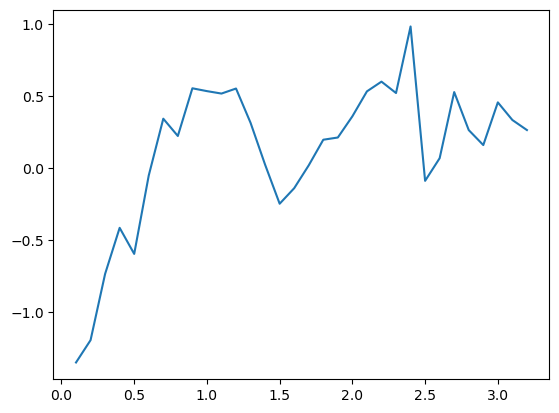

In [27]:
ts_ = np.arange(0.1,3.3,0.1)#np.sort(np.random.uniform(low=0.4, high=3.2, size=32))
ts_ext_ = np.array([0.] + list(ts_) + [3.3])
ts_vis_ = np.linspace(0., 3.3, 300)
ys_ = x_sel#np.sin(ts_ * (2. * math.pi))[:, None] * 0.8

ts = torch.tensor(ts_).float()
ts_ext = torch.tensor(ts_ext_).float()
ts_vis = torch.tensor(ts_vis_).float()
ys = torch.tensor(ys_).float().to(device)[:,None]

plt.plot(ts_,ys_)

print(ts)

print(ys.size())



In [28]:
import scipy.stats as ss
XX = ys_[:-1,0]
YY = ys_[1:,0]
dt = .1
res = ss.linregress(XX, YY)  # OLS
alpha = res.intercept
beta = res.slope
kappa_ols = -np.log(beta) / dt
theta_ols = alpha / (1 - beta)
res = YY - beta * XX - alpha  # residuals
std_resid = np.std(res, ddof=2)
sig_ols = std_resid * np.sqrt(2 * kappa_ols / (1 - beta**2))

print("OLS mu = ", theta_ols)
print("OLS theta = ", kappa_ols)
print("OLS sigma = ", sig_ols)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [36]:
# Plotting parameters.
vis_batch_size = 1024
ylims = (-1.75, 1.75)
alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
vis_idx = np.random.permutation(vis_batch_size)
# From https://colorbrewer2.org/.
if True:
    sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
    fill_color = '#9ebcda'
    mean_color = '#4d004b'
    num_samples = len(sample_colors)


In [37]:
eps = torch.randn(vis_batch_size, 1).to(device)  # Fix seed for the random draws used in the plots.
bm = torchsde.BrownianInterval(
    t0=ts_vis_[0],
    t1=ts_vis_[-1],
    size=(vis_batch_size, 1),
    device=device,
    levy_area_approximation='space-time'
)  # We need space-time Levy area to use the SRK solver

In [38]:
# Model.
model = LatentSDE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
kl_scheduler = LinearScheduler(iters=100)

logpy_metric = EMAMetric()
kl_metric = EMAMetric()
loss_metric = EMAMetric()

In [39]:
if True:
        with torch.no_grad():
            zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
            ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
            zs_ = np.sort(zs_, axis=1)

            plt.subplot(frameon=False)
            for alpha, percentile in zip(alphas, percentiles):
                idx = int((1 - percentile) / 2. * vis_batch_size)
                zs_bot_ = zs_[:, idx]
                zs_top_ = zs_[:, -idx]
                plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

            # `zorder` determines who's on top; the larger the more at the top.
            plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')
            plt.tight_layout()
            plt.show()
            #plt.savefig(img_dir, dpi=args.dpi)
            #plt.close()
            #logging.info(f'Saved prior figure at: {img_dir}')

AttributeError: 'float' object has no attribute 'size'

  0%|          | 0/200 [00:00<?, ?it/s]

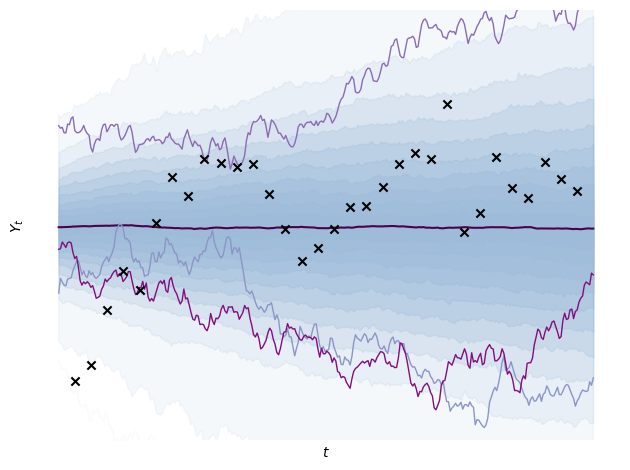

 25%|██▌       | 50/200 [01:05<03:06,  1.25s/it]

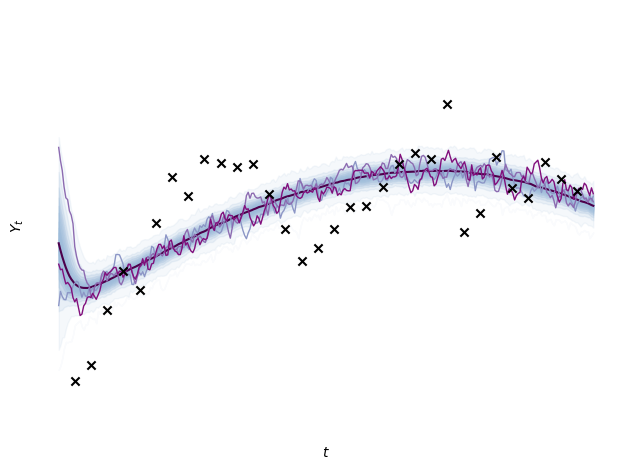

 50%|█████     | 100/200 [02:13<02:07,  1.28s/it]

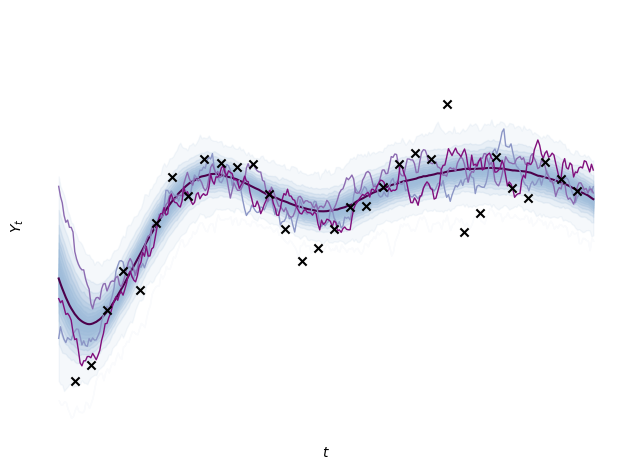

 75%|███████▌  | 150/200 [03:20<01:04,  1.28s/it]

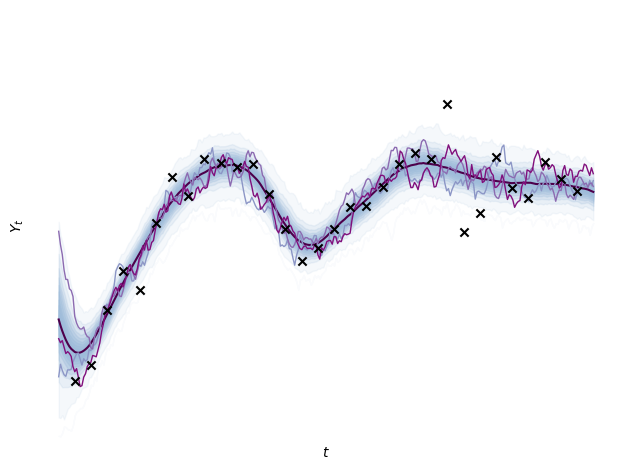

100%|██████████| 200/200 [04:28<00:00,  1.34s/it]


In [248]:
train_iters = 200
pause_iters = 50
for global_step in tqdm.tqdm(range(train_iters)):
        # Plot and save.
        if global_step % pause_iters == 0:

            with torch.no_grad():
                zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
                samples = zs[:, vis_idx]
                ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
                zs_ = np.sort(zs_, axis=1)
                plt.subplot(frameon=False)

                if True:
                    for alpha, percentile in zip(alphas, percentiles):
                        idx = int((1 - percentile) / 2. * vis_batch_size)
                        zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
                        plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

                if True:
                    plt.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

                if True:
                    for j in range(num_samples):
                        plt.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)

                if False:
                    num, dt = 12, 0.12
                    t, y = torch.meshgrid(
                        [torch.linspace(0.2, 1.8, num).to(device), torch.linspace(-1.5, 1.5, num).to(device)]
                    )
                    t, y = t.reshape(-1, 1), y.reshape(-1, 1)
                    fty = model.f(t=t, y=y).reshape(num, num)
                    dt = torch.zeros(num, num).fill_(dt).to(device)
                    dy = fty * dt
                    dt_, dy_, t_, y_ = dt.cpu().numpy(), dy.cpu().numpy(), t.cpu().numpy(), y.cpu().numpy()
                    plt.quiver(t_, y_, dt_, dy_, alpha=0.3, edgecolors='k', width=0.0035, scale=50)

                if True:
                    plt.xticks([], [])
                    plt.yticks([], [])

                plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
                plt.ylim(ylims)
                plt.xlabel('$t$')
                plt.ylabel('$Y_t$')
                plt.tight_layout()
                plt.show()


        # Train.
        optimizer.zero_grad()
        zs, kl = model(ts=ts_ext, batch_size=512)
        zs = zs.squeeze()
        zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.

        likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}['laplace']
        likelihood = likelihood_constructor(loc=zs, scale=0.05)
        logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0)

        loss = -logpy + kl * kl_scheduler.val
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

        logpy_metric.step(logpy)
        kl_metric.step(kl)
        loss_metric.step(loss)


# SDE based on Lorenz Attractor

[[ 4.84509802e+02  1.06710036e-06 -7.48286539e-07]
 [ 1.06710036e-06  2.23133666e+02  1.00185689e-06]
 [-7.48286539e-07  1.00185689e-06  7.11023874e+01]]


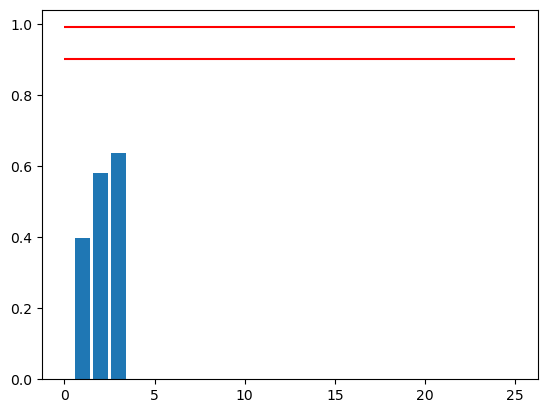

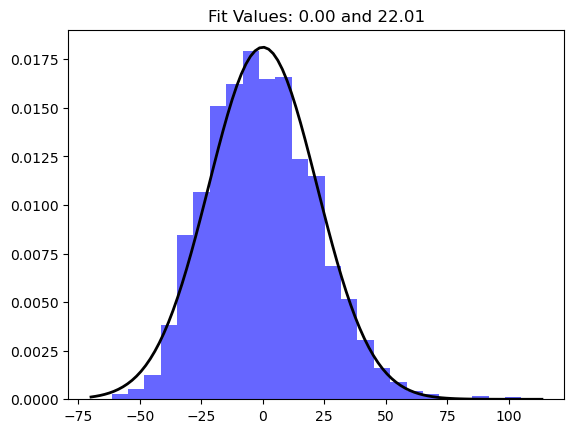

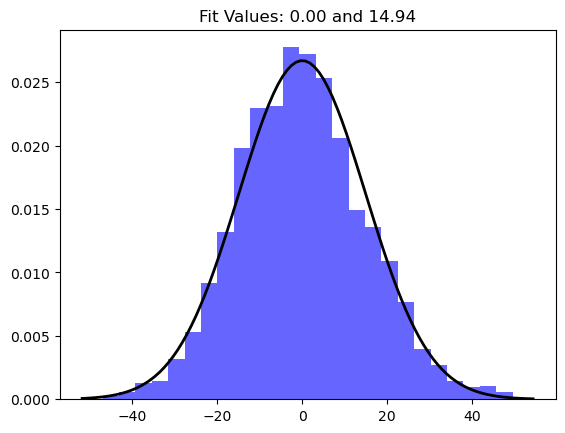

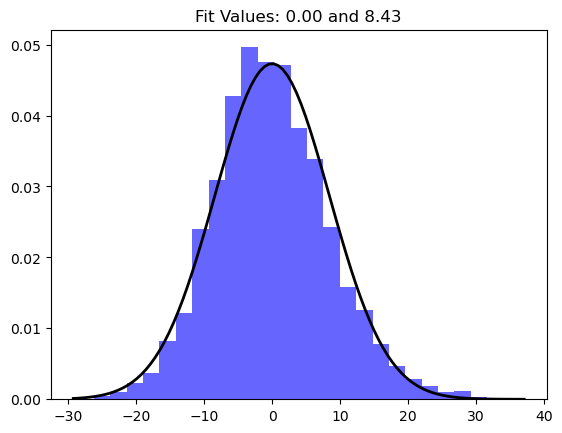

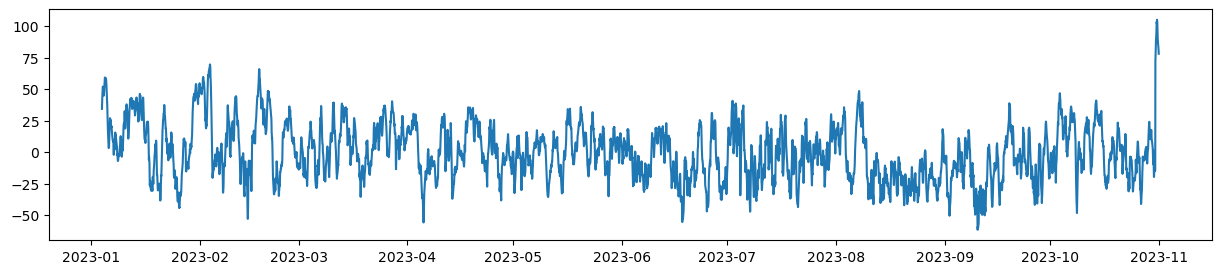

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.stats import norm 


nPCAc = 3
x_trans[np.isnan(x_trans)] = 0
Y = x_trans[:,:,:]
X = Y.reshape(Y.shape[0], -1)
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)
pca = PCA(n_components=nPCAc)
principalComponents_ERA5 = pca.fit_transform(X)

bla = principalComponents_ERA5[:150000,0]
for j in range(1,nPCAc):
    bla = np.vstack([bla, principalComponents_ERA5[:150000,j]])       
sigq = np.cov(bla)

print(sigq)


plt.figure(1)
plt.bar(np.linspace(1,pca.n_components_,pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y = 0.9,xmin= 0, xmax = 25,colors="red")
plt.hlines(y = 0.99,xmin= 0, xmax = 25,colors="red")
plt.show()

for i in range(nPCAc):

    #plt.figure(i+2, figsize=[15,3])
    #plt.plot(principalComponents_ERA5[:150000,i])

    mu, std = norm.fit(principalComponents_ERA5[:150000,i]) 
    plt.figure(i+2)
    plt.hist(principalComponents_ERA5[:150000,i], bins=25, density=True, alpha=0.6, color='b') 
    xmin, xmax = plt.xlim() 
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, mu, std) 
  
    plt.plot(x, p, 'k', linewidth=2) 
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
    plt.title(title) 

plt.figure(figsize=[15,3])
plt.plot(time_ly,principalComponents_ERA5[:150000,0])

In [8]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Train a latent SDE on data from a stochastic Lorenz attractor.

Reproduce the toy example in Section 7.2 of https://arxiv.org/pdf/2001.01328.pdf

To run this file, first run the following to install extra requirements:
pip install fire

To run, execute:
python -m examples.latent_sde_lorenz
"""
import logging
import os
from typing import Sequence

import fire
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

import torchsde


class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val


class StochasticLorenz(object):
    """Stochastic Lorenz attractor.

    Used for simulating ground truth and obtaining noisy data.
    Details described in Section 7.2 https://arxiv.org/pdf/2001.01328.pdf
    Default a, b from https://openreview.net/pdf?id=HkzRQhR9YX
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, a: Sequence = (10., 28., 8 / 3), b: Sequence = (.1, .28, .3)):
        super(StochasticLorenz, self).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        a1, a2, a3 = self.a

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3
        return torch.cat([f1, f2, f3], dim=1)

    def g(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        b1, b2, b3 = self.b

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3
        return torch.cat([g1, g2, g3], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts)
        
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        out, _ = self.gru(inp)
        out = self.lin(out)
        return out


class LatentSDE(nn.Module):
    sde_type = "stratonovich"
    noise_type = "diagonal"

    def __init__(self, data_size, latent_size, context_size, hidden_size):
        super(LatentSDE, self).__init__()
        # Encoder.
        self.encoder = Encoder(input_size=data_size, hidden_size=hidden_size, output_size=context_size)
        self.qz0_net = nn.Linear(context_size, latent_size + latent_size)

        # Decoder.
        self.f_net = nn.Sequential(
            nn.Linear(latent_size + context_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        self.h_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        # This needs to be an element-wise function for the SDE to satisfy diagonal noise.
        self.g_nets = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.Softplus(),
                    nn.Linear(hidden_size, 1),
                    nn.Sigmoid()
                )
                for _ in range(latent_size)
            ]
        )
        self.projector = nn.Linear(latent_size, data_size)

        self.pz0_mean = nn.Parameter(torch.zeros(1, latent_size))
        self.pz0_logstd = nn.Parameter(torch.zeros(1, latent_size))

        self._ctx = None

    def contextualize(self, ctx):
        self._ctx = ctx  # A tuple of tensors of sizes (T,), (T, batch_size, d).

    def f(self, t, y):
        ts, ctx = self._ctx
        i = min(torch.searchsorted(ts, t, right=True), len(ts) - 1)
        return self.f_net(torch.cat((y, ctx[i]), dim=1))

    def h(self, t, y):
        return self.h_net(y)

    def g(self, t, y):  # Diagonal diffusion.
        y = torch.split(y, split_size_or_sections=1, dim=1)
        out = [g_net_i(y_i) for (g_net_i, y_i) in zip(self.g_nets, y)]
        return torch.cat(out, dim=1)

    def forward(self, xs, ts, noise_std, adjoint=False, method="midpoint"):
        # Contextualization is only needed for posterior inference.
        ctx = self.encoder(torch.flip(xs, dims=(0,)))
        ctx = torch.flip(ctx, dims=(0,))
        self.contextualize((ts, ctx))

        qz0_mean, qz0_logstd = self.qz0_net(ctx[0]).chunk(chunks=2, dim=1)
        z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)

        if adjoint:
            # Must use the argument `adjoint_params`, since `ctx` is not part of the input to `f`, `g`, and `h`.
            adjoint_params = (
                    (ctx,) +
                    tuple(self.f_net.parameters()) + tuple(self.g_nets.parameters()) + tuple(self.h_net.parameters())
            )
            zs, log_ratio = torchsde.sdeint_adjoint(
                self, z0, ts, adjoint_params=adjoint_params, dt=1, logqp=True, method=method)
        else:
            zs, log_ratio = torchsde.sdeint(self, z0, ts, dt=1, logqp=True, method=method)

        _xs = self.projector(zs)
        xs_dist = Normal(loc=_xs, scale=noise_std)
        log_pxs = xs_dist.log_prob(xs).sum(dim=(0, 2)).mean(dim=0)

        qz0 = torch.distributions.Normal(loc=qz0_mean, scale=qz0_logstd.exp())
        pz0 = torch.distributions.Normal(loc=self.pz0_mean, scale=self.pz0_logstd.exp())
        logqp0 = torch.distributions.kl_divergence(qz0, pz0).sum(dim=1).mean(dim=0)
        logqp_path = log_ratio.sum(dim=0).mean(dim=0)
        return log_pxs, logqp0 + logqp_path

    @torch.no_grad()
    def sample(self, batch_size, ts, bm=None):
        eps = torch.randn(size=(batch_size, *self.pz0_mean.shape[1:]), device=self.pz0_mean.device)
        z0 = self.pz0_mean + self.pz0_logstd.exp() * eps
        zs = torchsde.sdeint(self, z0, ts, names={'drift': 'h'}, dt=1, bm=bm)
        # Most of the times in ML, we don't sample the observation noise for visualization purposes.
        _xs = self.projector(zs)
        return _xs


def make_dataset(t0, t1, batch_size, noise_std, train_dir, device):
    data_path = os.path.join('./', 'lorenz_data_test.pth')
    #os.makedirs(os.path.dirname(data_path), exist_ok=True)
    if os.path.exists(data_path):
        data_dict = torch.load(data_path)
        xs, ts = data_dict['xs'], data_dict['ts']
        logging.warning(f'Loaded toy data at: {data_path}')
        if xs.shape[1] != batch_size:
            raise ValueError("Batch size has changed; please delete and regenerate the data.")
        if ts[0] != t0 or ts[-1] != t1:
            raise ValueError("Times interval [t0, t1] has changed; please delete and regenerate the data.")
    else:
        _y0 = torch.randn(batch_size, 3, device=device)
        ts = torch.linspace(t0, t1, steps=25, device=device)
        xs = StochasticLorenz().sample(_y0, ts, noise_std, normalize=True)

        os.makedirs(os.path.dirname(data_path), exist_ok=True)
        torch.save({'xs': xs, 'ts': ts}, data_path)
        logging.warning(f'Stored toy data at: {data_path}')
    return xs, ts


def vis(xs, ts, latent_sde, bm_vis, img_path, num_samples=10):
    fig = plt.figure(figsize=(20, 9))
    gs = gridspec.GridSpec(1, 2)
    ax00 = fig.add_subplot(gs[0, 0], projection='3d')
    ax01 = fig.add_subplot(gs[0, 1], projection='3d')

    # Left plot: data.
    z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
    [ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
    ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :10, 0], marker='x')
    ax00.set_yticklabels([])
    ax00.set_xticklabels([])
    ax00.set_zticklabels([])
    ax00.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax00.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax00.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax00.set_title('Data', fontsize=20)
    xlim = ax00.get_xlim()
    ylim = ax00.get_ylim()
    zlim = ax00.get_zlim()

    # Right plot: samples from learned model.
    xs = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis).cpu().numpy()
    z1, z2, z3 = np.split(xs, indices_or_sections=3, axis=-1)

    [ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
    ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :10, 0], marker='x')
    ax01.set_yticklabels([])
    ax01.set_xticklabels([])
    ax01.set_zticklabels([])
    ax01.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax01.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax01.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax01.set_title('Samples', fontsize=20)
    ax01.set_xlim(xlim)
    ax01.set_ylim(ylim)
    ax01.set_zlim(zlim)

    plt.show()





In [9]:
import logging
import os
from typing import Sequence

import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

import torchsde

In [10]:
batch_size=8#512#1024
latent_size=4
context_size=8
hidden_size=8#2#128
lr_init=1e-2#1e-2
t0=0.
t1=25.
lr_gamma=0.997
num_iters=500#5000
kl_anneal_iters=1000
pause_every=1
noise_std=0.1
adjoint=False
train_dir='./'
method="milstein"

num_samples=batch_size


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dir='./'
print(device)


xs, ts = make_dataset(t0=t0, t1=t1, batch_size=batch_size, noise_std=noise_std, train_dir=train_dir, device=device)

cpu


In [12]:
print(xs.dtype)

torch.float32


In [13]:
print(ts)
print(ts.size())
print(ts.type())

tensor([ 0.0000,  1.0417,  2.0833,  3.1250,  4.1667,  5.2083,  6.2500,  7.2917,
         8.3333,  9.3750, 10.4167, 11.4583, 12.5000, 13.5417, 14.5833, 15.6250,
        16.6667, 17.7083, 18.7500, 19.7917, 20.8333, 21.8750, 22.9167, 23.9583,
        25.0000])
torch.Size([25])
torch.FloatTensor


In [277]:
print(xs.size())

torch.Size([25, 8, 3])


In [11]:
xcoord = 8
ycoord = 1

ws_mean = np.mean(ws_ly[21,0:xcoord,:ycoord])
ws_std = np.std(ws_ly[21,0:xcoord,:ycoord])
t_mean = np.mean(t_ly[21,0:xcoord,:ycoord])
t_std = np.std(t_ly[21,0:xcoord,:ycoord])
z_mean = np.mean(z_ly[21,0:xcoord,:ycoord])
z_std = np.std(z_ly[21,0:xcoord,:ycoord])

ws_ly = (ws_ly-ws_mean)/ws_std
t_ly = (t_ly-t_mean)/t_std
z_ly = (z_ly-z_mean)/z_std

ws_test = torch.tensor(ws_ly[21:46,0:xcoord,:ycoord])
temp_test = torch.tensor(t_ly[21:46,0:xcoord,:ycoord])
gp_test = torch.tensor(t_ly[21:46,0:xcoord,:ycoord])




print(len(ws_ma[0:25,0,0]))
print(len(ws_ma[0,:,0]))
print(len(ws_ma[0,0,:]))

for i in range(25):
    print(i)
    for j in range(xcoord):
        for k in range(ycoord):
            #plt.plot(temp_test[0:25,j,k])
            xs[i,j+k,0] = ws_test[i,j,k]
            xs[i,j+k,1] = temp_test[i,j,k]
            xs[i,j+k,2] = gp_test[i,j,k]





25
33
37
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [12]:
print(xs.size())

torch.Size([25, 8, 3])


In [280]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [13]:

latent_sde = LatentSDE(
        data_size=3,
        latent_size=latent_size,
        context_size=context_size,
        hidden_size=hidden_size,
    ).to(device)

optimizer = optim.Adam(params=latent_sde.parameters(), lr=lr_init)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=lr_gamma)
kl_scheduler = LinearScheduler(iters=kl_anneal_iters)

# Fix the same Brownian motion for visualization.
bm_vis = torchsde.BrownianInterval(
        t0=t0, t1=t1, size=(batch_size, latent_size,), device=device, levy_area_approximation="space-time")

In [284]:
num_iters = 20000
for global_step in tqdm.tqdm(range(1, num_iters + 1)):
    latent_sde.zero_grad()
    log_pxs, log_ratio = latent_sde(xs, ts, noise_std, adjoint, method)
    loss = -log_pxs + log_ratio * kl_scheduler.val
    loss.backward()
    optimizer.step()
    scheduler.step()
    kl_scheduler.step()



    

100%|██████████| 20000/20000 [32:45<00:00, 10.18it/s] 


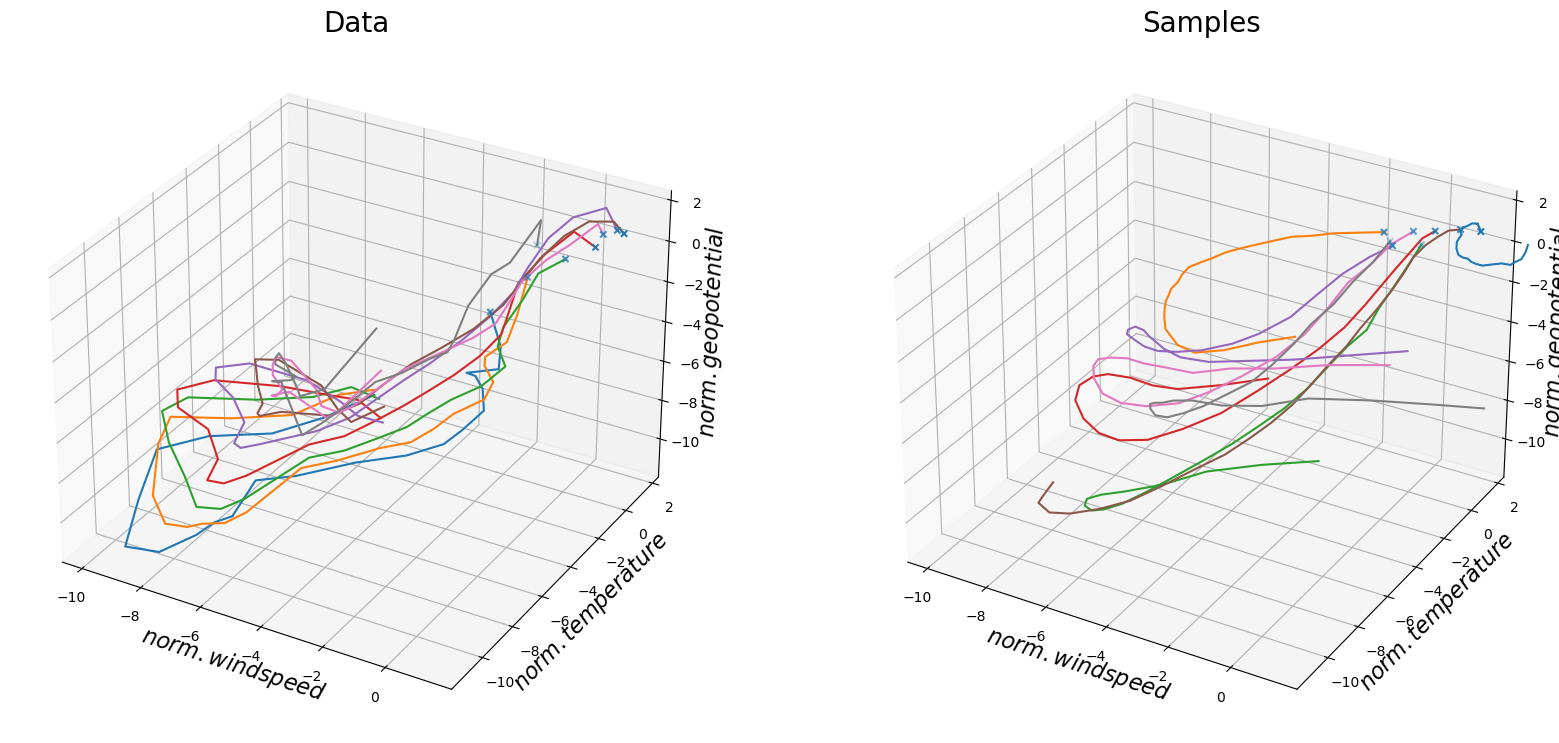

In [285]:
#Stratonovich 40000 Iteratione
xs_l = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis)

fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(1, 2)
ax00 = fig.add_subplot(gs[0, 0], projection='3d')
ax01 = fig.add_subplot(gs[0, 1], projection='3d')


# Left plot: data.
z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
#ax00.set_yticklabels([])
#ax00.set_xticklabels([])
#ax00.set_zticklabels([])
ax00.set_xlabel('$norm. wind speed$', labelpad=0., fontsize=16)
ax00.set_ylabel('$norm. temperature$', labelpad=.5, fontsize=16)
ax00.set_zlabel('$norm. geopotential$', labelpad=0., horizontalalignment='center', fontsize=16)
ax00.set_title('Data', fontsize=20)
xlim = ax00.get_xlim()
ylim = ax00.get_ylim()
zlim = ax00.get_zlim()

        # Left plot: data.
z1, z2, z3 = np.split(xs_l.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
#ax01.set_yticklabels([])
#ax01.set_xticklabels([])
#ax01.set_zticklabels([])
ax01.set_xlabel('$norm. wind speed$', labelpad=0., fontsize=16)
ax01.set_ylabel('$norm. temperature$', labelpad=.5, fontsize=16)
ax01.set_zlabel('$norm. geopotential$', labelpad=0., horizontalalignment='center', fontsize=16)
ax01.set_title('Samples', fontsize=20)
ax01.set_xlim(xlim)
ax01.set_ylim(ylim)
ax01.set_zlim(zlim)

plt.show()

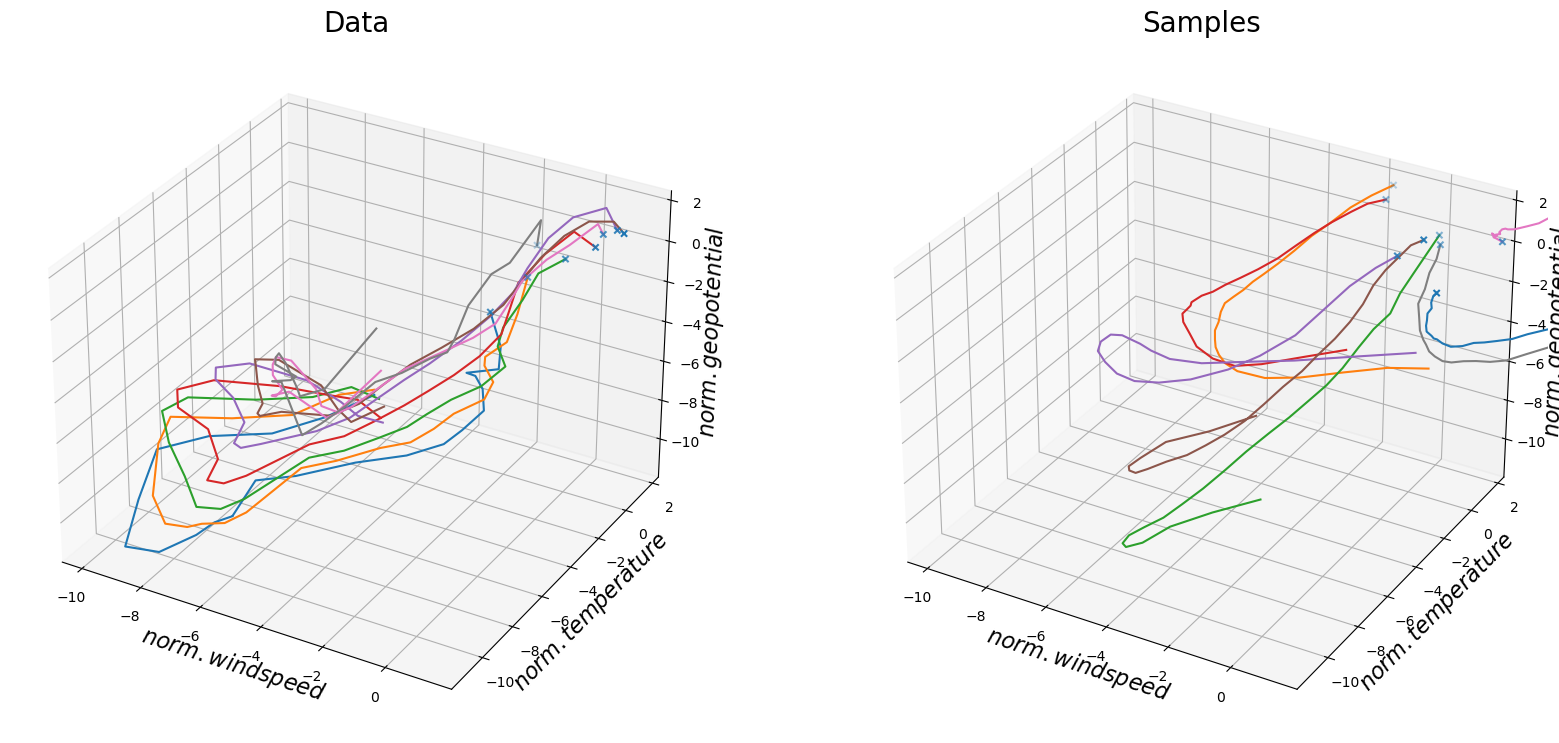

In [283]:
#Stratonovich 20000 Iteratione
xs_l = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis)

fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(1, 2)
ax00 = fig.add_subplot(gs[0, 0], projection='3d')
ax01 = fig.add_subplot(gs[0, 1], projection='3d')


# Left plot: data.
z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
#ax00.set_yticklabels([])
#ax00.set_xticklabels([])
#ax00.set_zticklabels([])
ax00.set_xlabel('$norm. wind speed$', labelpad=0., fontsize=16)
ax00.set_ylabel('$norm. temperature$', labelpad=.5, fontsize=16)
ax00.set_zlabel('$norm. geopotential$', labelpad=0., horizontalalignment='center', fontsize=16)
ax00.set_title('Data', fontsize=20)
xlim = ax00.get_xlim()
ylim = ax00.get_ylim()
zlim = ax00.get_zlim()

        # Left plot: data.
z1, z2, z3 = np.split(xs_l.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
#ax01.set_yticklabels([])
#ax01.set_xticklabels([])
#ax01.set_zticklabels([])
ax01.set_xlabel('$norm. wind speed$', labelpad=0., fontsize=16)
ax01.set_ylabel('$norm. temperature$', labelpad=.5, fontsize=16)
ax01.set_zlabel('$norm. geopotential$', labelpad=0., horizontalalignment='center', fontsize=16)
ax01.set_title('Samples', fontsize=20)
ax01.set_xlim(xlim)
ax01.set_ylim(ylim)
ax01.set_zlim(zlim)

plt.show()

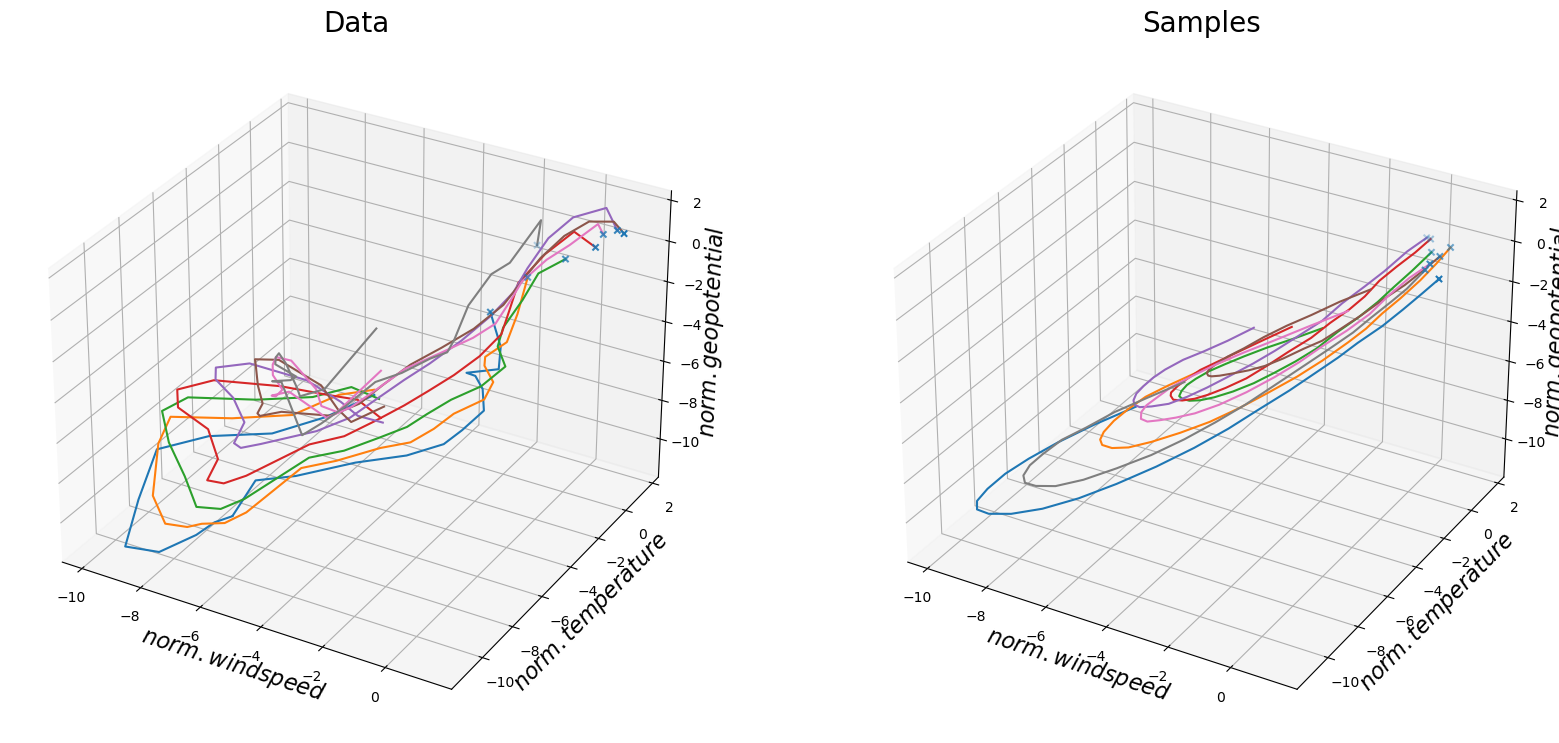

In [271]:
#ITO 40000 Iteratione
xs_l = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis)

fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(1, 2)
ax00 = fig.add_subplot(gs[0, 0], projection='3d')
ax01 = fig.add_subplot(gs[0, 1], projection='3d')


# Left plot: data.
z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
#ax00.set_yticklabels([])
#ax00.set_xticklabels([])
#ax00.set_zticklabels([])
ax00.set_xlabel('$norm. wind speed$', labelpad=0., fontsize=16)
ax00.set_ylabel('$norm. temperature$', labelpad=.5, fontsize=16)
ax00.set_zlabel('$norm. geopotential$', labelpad=0., horizontalalignment='center', fontsize=16)
ax00.set_title('Data', fontsize=20)
xlim = ax00.get_xlim()
ylim = ax00.get_ylim()
zlim = ax00.get_zlim()

        # Left plot: data.
z1, z2, z3 = np.split(xs_l.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
#ax01.set_yticklabels([])
#ax01.set_xticklabels([])
#ax01.set_zticklabels([])
ax01.set_xlabel('$norm. wind speed$', labelpad=0., fontsize=16)
ax01.set_ylabel('$norm. temperature$', labelpad=.5, fontsize=16)
ax01.set_zlabel('$norm. geopotential$', labelpad=0., horizontalalignment='center', fontsize=16)
ax01.set_title('Samples', fontsize=20)
ax01.set_xlim(xlim)
ax01.set_ylim(ylim)
ax01.set_zlim(zlim)

plt.show()

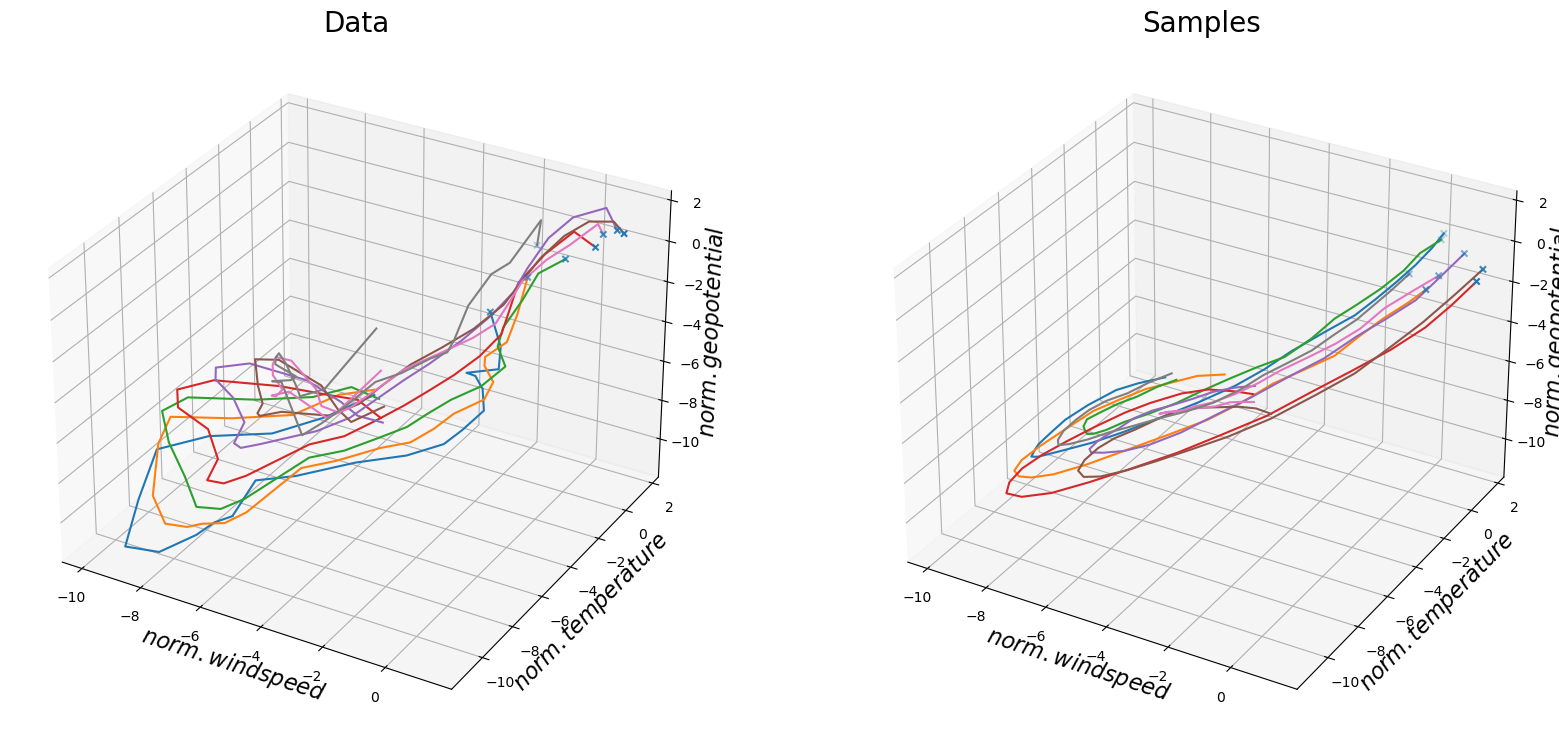

In [265]:
#ITO 20000 Iteratione
xs_l = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis)

fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(1, 2)
ax00 = fig.add_subplot(gs[0, 0], projection='3d')
ax01 = fig.add_subplot(gs[0, 1], projection='3d')


# Left plot: data.
z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
#ax00.set_yticklabels([])
#ax00.set_xticklabels([])
#ax00.set_zticklabels([])
ax00.set_xlabel('$norm. wind speed$', labelpad=0., fontsize=16)
ax00.set_ylabel('$norm. temperature$', labelpad=.5, fontsize=16)
ax00.set_zlabel('$norm. geopotential$', labelpad=0., horizontalalignment='center', fontsize=16)
ax00.set_title('Data', fontsize=20)
xlim = ax00.get_xlim()
ylim = ax00.get_ylim()
zlim = ax00.get_zlim()

        # Left plot: data.
z1, z2, z3 = np.split(xs_l.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
#ax01.set_yticklabels([])
#ax01.set_xticklabels([])
#ax01.set_zticklabels([])
ax01.set_xlabel('$norm. wind speed$', labelpad=0., fontsize=16)
ax01.set_ylabel('$norm. temperature$', labelpad=.5, fontsize=16)
ax01.set_zlabel('$norm. geopotential$', labelpad=0., horizontalalignment='center', fontsize=16)
ax01.set_title('Samples', fontsize=20)
ax01.set_xlim(xlim)
ax01.set_ylim(ylim)
ax01.set_zlim(zlim)

plt.show()

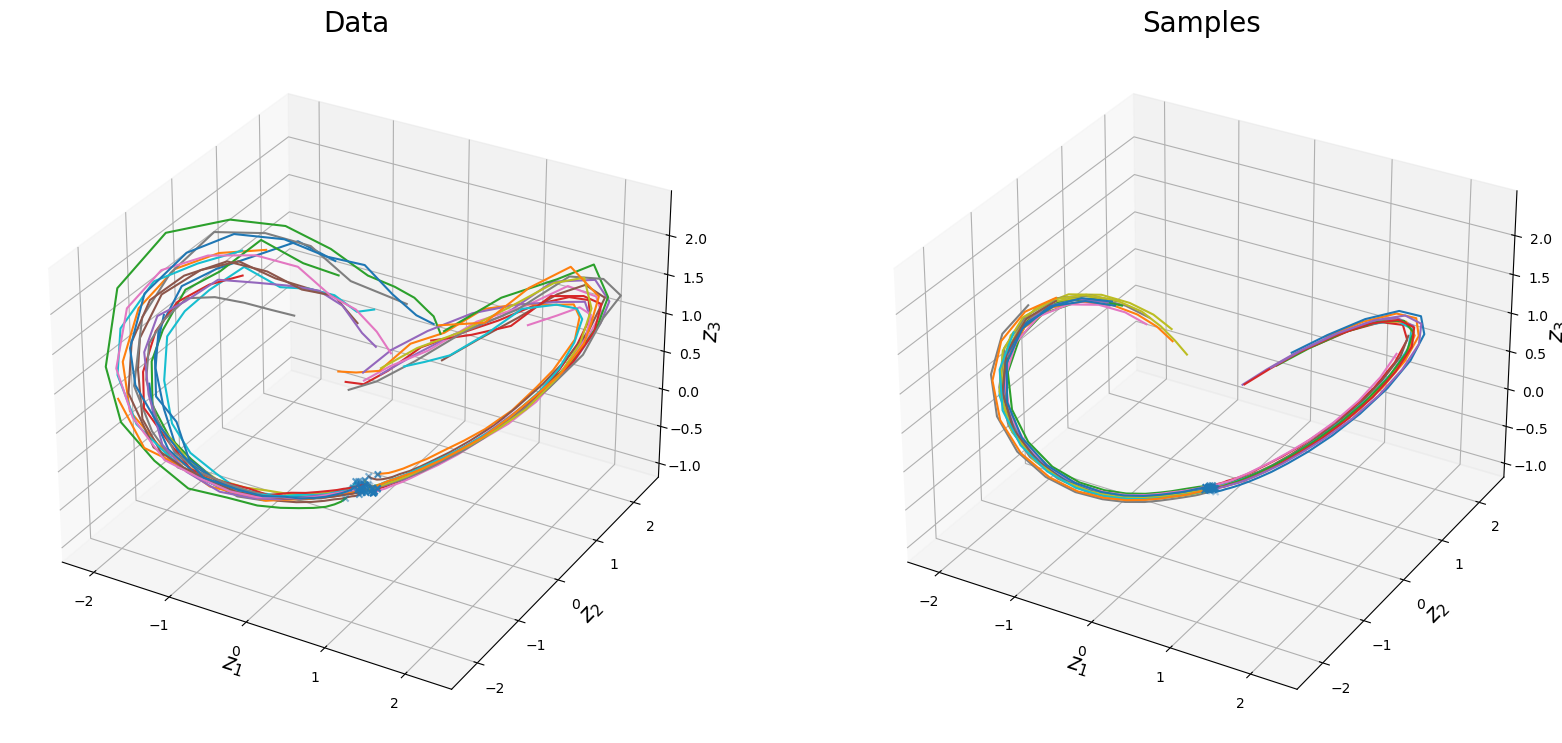

In [239]:
num_samples = 32
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(1, 2)
ax00 = fig.add_subplot(gs[0, 0], projection='3d')
ax01 = fig.add_subplot(gs[0, 1], projection='3d')


# Left plot: data.
z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
#ax00.set_yticklabels([])
#ax00.set_xticklabels([])
#ax00.set_zticklabels([])
ax00.set_xlabel('$z_1$', labelpad=0., fontsize=16)
ax00.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
ax00.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
ax00.set_title('Data', fontsize=20)
xlim = ax00.get_xlim()
ylim = ax00.get_ylim()
zlim = ax00.get_zlim()

        # Left plot: data.
z1, z2, z3 = np.split(xs_l.cpu().numpy(), indices_or_sections=3, axis=-1)
[ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
#ax01.set_yticklabels([])
#ax01.set_xticklabels([])
#ax01.set_zticklabels([])
ax01.set_xlabel('$z_1$', labelpad=0., fontsize=16)
ax01.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
ax01.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
ax01.set_title('Samples', fontsize=20)
ax01.set_xlim(xlim)
ax01.set_ylim(ylim)
ax01.set_zlim(zlim)

plt.show()

# torchdyn: Stable Neural ODEs (Stable Neural Flows)

In [18]:
from torchdyn.core import NeuralODE, ODEProblem
from torchdyn.nn import DataControl, DepthCat, Augmenter
from torchdyn.datasets import *
from torchdyn.utils import *
import torch
import torch.nn as nn

In [19]:
x1_ = ws_ma[0:300,15,15]
x2_ = t_ma[0:300,15,15]

dx1_ = np.gradient(ws_ma[0:300,15:17,15])
dx2_ = np.gradient(t_ma[0:300,15:17,15])

dX_ = np.vstack((dx1_, dx2_)).T
dX = torch.tensor(dX_)

X_ = np.vstack((x1_, x2_)).T
X = torch.tensor(X_)







In [20]:
print(X.size())

torch.Size([300, 2])


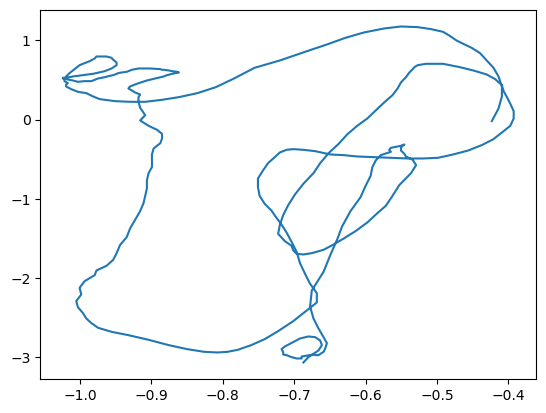

In [21]:
plt.plot(X_[:,0],X_[:,1])


In [22]:
bla = torch.gradient(X[:,0])
print(bla)

(tensor([ 0.0094,  0.0071,  0.0024, -0.0024, -0.0059, -0.0082, -0.0094, -0.0106,
        -0.0118, -0.0106, -0.0094, -0.0094, -0.0130, -0.0177, -0.0212, -0.0236,
        -0.0259, -0.0271, -0.0259, -0.0283, -0.0330, -0.0353, -0.0330, -0.0271,
        -0.0247, -0.0259, -0.0247, -0.0236, -0.0224, -0.0212, -0.0212, -0.0153,
        -0.0094, -0.0106, -0.0106, -0.0082, -0.0035,  0.0012, -0.0012, -0.0024,
         0.0012,  0.0035,  0.0059,  0.0071,  0.0071,  0.0071,  0.0071,  0.0047,
         0.0035,  0.0047,  0.0047,  0.0059,  0.0047,  0.0035,  0.0024, -0.0035,
        -0.0082, -0.0130, -0.0153, -0.0141, -0.0118, -0.0071, -0.0024,  0.0012,
         0.0024,  0.0035,  0.0047,  0.0059,  0.0082,  0.0094,  0.0059,  0.0047,
         0.0082,  0.0082,  0.0059,  0.0035,  0.0024,  0.0024,  0.0035,  0.0059,
         0.0071,  0.0082,  0.0130,  0.0153,  0.0082,  0.0024,  0.0047,  0.0059,
         0.0059,  0.0047, -0.0012, -0.0047, -0.0059, -0.0059, -0.0082, -0.0118,
        -0.0130, -0.0118, -0.0059,  0.0

In [23]:
diff = X[1:,:] - X[:-1,:]
print(diff)

tensor([[ 0.0094,  0.1598],
        [ 0.0047,  0.1515],
        [ 0.0000,  0.1262],
        [-0.0047,  0.1262],
        [-0.0071,  0.1094],
        [-0.0094,  0.0925],
        [-0.0094,  0.0926],
        [-0.0118,  0.0673],
        [-0.0118,  0.0505],
        [-0.0094,  0.0421],
        [-0.0094,  0.0589],
        [-0.0094,  0.0505],
        [-0.0165,  0.0337],
        [-0.0189,  0.0252],
        [-0.0236,  0.0084],
        [-0.0236, -0.0252],
        [-0.0283, -0.0505],
        [-0.0259, -0.0673],
        [-0.0259, -0.0841],
        [-0.0306, -0.0926],
        [-0.0353, -0.1094],
        [-0.0353, -0.0925],
        [-0.0306, -0.1430],
        [-0.0236, -0.1009],
        [-0.0259, -0.0757],
        [-0.0259, -0.0505],
        [-0.0236, -0.0337],
        [-0.0236, -0.0252],
        [-0.0212,  0.0000],
        [-0.0212,  0.0084],
        [-0.0212,  0.0252],
        [-0.0094,  0.0337],
        [-0.0094,  0.0421],
        [-0.0118,  0.0168],
        [-0.0094,  0.0337],
        [-0.0071,  0

In [24]:
# quick run for automated notebook validation
dry_run = False

In [25]:
# Vanilla Version of stable neural flows
class Stable(nn.Module):
    """Stable Neural Flow"""
    def __init__(self, net, depthvar=False, controlled=False):
        super().__init__()
        self.net, self.depthvar, self.controlled = net, depthvar, controlled
        
    def forward(self, x):
        with torch.set_grad_enabled(True):
            bs, n = x.shape[0], x.shape[1] // 2
            x = x.requires_grad_(True)
            eps = self.net(x).sum()
            out = -torch.autograd.grad(eps, x, allow_unused=False, create_graph=True)[0] 
        out = out[:,:-1] if self.depthvar else out
        out = out[:,:-2] if self.controlled else out
        return out

In [26]:
# Conservative variant of stable neural flow
class ConservativeStable(nn.Module):
    """Conservative Stable Neural Flow"""
    def __init__(self, net, depthvar=False, controlled=False):
        super().__init__()
        self.net, self.depthvar, self.controlled = net, depthvar, controlled
        self.M = torch.nn.Parameter(torch.randn(2,2)).to(device)
    
    # impose the system matrix to be skew symmetric
    def Skew(self):
        return .5*(self.M - self.M.T)

    def forward(self, x):
        with torch.set_grad_enabled(True):
            bs, n = x.shape[0], x.shape[1] // 2
            x = x.requires_grad_(True)
            eps = self.net(x).sum()
            out = -torch.autograd.grad(eps, x, allow_unused=False, create_graph=True)[0] 
            #self.out = out
        out = out[:,:-1] if self.depthvar else out
        out = out[:,:-2] if self.controlled else out
        return out @ self.Skew()

In [27]:
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Data
#vf = odefunc(sys)
#X = 4*torch.rand(2048,2).to(device)
y = X[1:,:] - X[:-1,:]#vf(X)
X = X.to(device)
train = data.TensorDataset(X[:-1,:], y)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

In [28]:
print(X)

tensor([[-0.4233, -0.0194],
        [-0.4139,  0.1404],
        [-0.4091,  0.2919],
        [-0.4091,  0.4180],
        [-0.4139,  0.5442],
        [-0.4209,  0.6536],
        [-0.4304,  0.7461],
        [-0.4398,  0.8387],
        [-0.4516,  0.9060],
        [-0.4633,  0.9565],
        [-0.4728,  0.9985],
        [-0.4822,  1.0574],
        [-0.4916,  1.1079],
        [-0.5081,  1.1415],
        [-0.5270,  1.1668],
        [-0.5505,  1.1752],
        [-0.5741,  1.1500],
        [-0.6024,  1.0995],
        [-0.6283,  1.0322],
        [-0.6542,  0.9481],
        [-0.6849,  0.8555],
        [-0.7202,  0.7461],
        [-0.7556,  0.6536],
        [-0.7862,  0.5106],
        [-0.8098,  0.4096],
        [-0.8357,  0.3339],
        [-0.8616,  0.2834],
        [-0.8852,  0.2498],
        [-0.9087,  0.2245],
        [-0.9300,  0.2245],
        [-0.9512,  0.2330],
        [-0.9724,  0.2582],
        [-0.9818,  0.2919],
        [-0.9912,  0.3339],
        [-1.0030,  0.3507],
        [-1.0124,  0

In [29]:
print(y)

tensor([[ 0.0094,  0.1598],
        [ 0.0047,  0.1515],
        [ 0.0000,  0.1262],
        [-0.0047,  0.1262],
        [-0.0071,  0.1094],
        [-0.0094,  0.0925],
        [-0.0094,  0.0926],
        [-0.0118,  0.0673],
        [-0.0118,  0.0505],
        [-0.0094,  0.0421],
        [-0.0094,  0.0589],
        [-0.0094,  0.0505],
        [-0.0165,  0.0337],
        [-0.0189,  0.0252],
        [-0.0236,  0.0084],
        [-0.0236, -0.0252],
        [-0.0283, -0.0505],
        [-0.0259, -0.0673],
        [-0.0259, -0.0841],
        [-0.0306, -0.0926],
        [-0.0353, -0.1094],
        [-0.0353, -0.0925],
        [-0.0306, -0.1430],
        [-0.0236, -0.1009],
        [-0.0259, -0.0757],
        [-0.0259, -0.0505],
        [-0.0236, -0.0337],
        [-0.0236, -0.0252],
        [-0.0212,  0.0000],
        [-0.0212,  0.0084],
        [-0.0212,  0.0252],
        [-0.0094,  0.0337],
        [-0.0094,  0.0421],
        [-0.0118,  0.0168],
        [-0.0094,  0.0337],
        [-0.0071,  0

In [30]:
import pytorch_lightning as pl
import copy
        
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        return self.model.defunc(0,x)
    
    def loss(self, y, y_hat):
        return ((y-y_hat)**2).sum(1).mean()
    
    def training_step(self, batch, batch_idx):
        x = torch.randn(300,2).to(device)
        y = x[1:,:] - x[:-1,:]#vf(x)
        x = x[:-1,:]
        y_hat = self.model.vf(0,x)   
        loss = self.loss(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train_dataloader(self):
        return trainloader

In [31]:
# vector field parametrized by a NN
h_dim = 1#128
f = Stable(nn.Sequential(
                  nn.Linear(2,h_dim),
                  nn.Tanh(), 
                  nn.Linear(h_dim,h_dim),
                  nn.Tanh(),
                  nn.Linear(h_dim,h_dim),
                  nn.Tanh(),
                  nn.Linear(h_dim, 1)))            

# neural ODE
model = NeuralODE(f, 
                 order=1,
                 solver='dopri5', 
                 sensitivity='adjoint').to(device)
seq = nn.Sequential(model).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [32]:
learn = Learner(model)
if dry_run: trainer = pl.Trainer(max_epochs=1)
else: trainer = pl.Trainer(max_epochs=1000)
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Anwender\.conda\envs\rivapy\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 9     
------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)
c:\Users\Anwender\.conda\envs\rivapy\lib\site-p

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\Anwender\.conda\envs\rivapy\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


torch.Size([10, 300, 2])
tensor([5.6200, 5.6600, 5.6800, 5.6800, 5.6600, 5.6300, 5.5900, 5.5500, 5.5000,
        5.4500, 5.4100, 5.3700, 5.3300, 5.2600, 5.1800, 5.0800, 4.9800, 4.8600,
        4.7500, 4.6400, 4.5100, 4.3600, 4.2100, 4.0800, 3.9800, 3.8700, 3.7600,
        3.6600, 3.5600, 3.4700, 3.3800, 3.2900, 3.2500, 3.2100, 3.1600, 3.1200,
        3.0900, 3.0900, 3.1000, 3.0800, 3.0800, 3.0900, 3.1100, 3.1400, 3.1700,
        3.2000, 3.2300, 3.2600, 3.2700, 3.2900, 3.3100, 3.3300, 3.3600, 3.3700,
        3.3900, 3.3900, 3.3600, 3.3200, 3.2500, 3.1900, 3.1300, 3.0900, 3.0700,
        3.0700, 3.0800, 3.0900, 3.1100, 3.1300, 3.1600, 3.2000, 3.2400, 3.2500,
        3.2800, 3.3200, 3.3500, 3.3700, 3.3800, 3.3900, 3.4000, 3.4200, 3.4500,
        3.4800, 3.5200, 3.5900, 3.6500, 3.6600, 3.6700, 3.7000, 3.7200, 3.7500,
        3.7600, 3.7400, 3.7200, 3.6900, 3.6700, 3.6200, 3.5700, 3.5100, 3.4700,
        3.4600, 3.4800, 3.5000, 3.5300, 3.5200, 3.5200, 3.5300, 3.5600, 3.5300,
        3.5800,

Text(0.5, 1.0, 'Data')

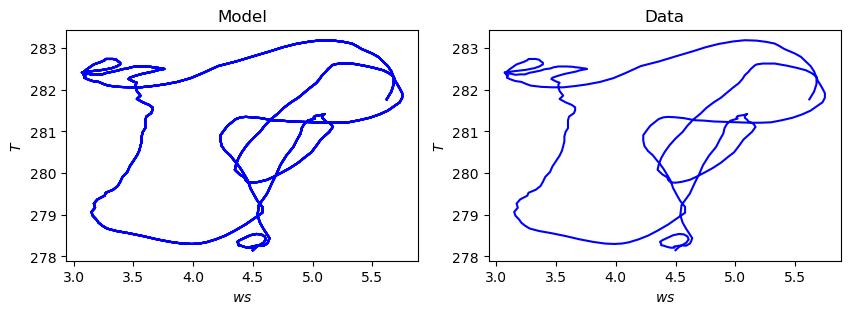

In [ ]:
#system = system.to(device)
model = model.to(device)

# Sample random initial conditions
#X_t = torch.randn(296, 2).to(device)
# Evaluate the model's trajectories
t_span = torch.linspace(0, 5, 10)
#_, sys_traj = system(X_t, t_span)
#sys_traj = sys_traj.detach().cpu()
traj = model.trajectory(X, t_span).detach().cpu()


print(traj.size())

print(traj[0,:,0])

# Plot the  trajectories with random ICs
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(len(t_span)):
    ax.plot(traj[i,:,0], traj[i,:,1], color='blue')#, alpha=0.1);
#ax.set_xlim([-3,3])
#ax.set_ylim([-3,3])
ax.set_xlabel(r"$ws$")
ax.set_ylabel(r"$T$")
ax.set_title("Model")


#for i in range(len(X_t)):
ax2.plot(X_[:,0],X_[:,1], color='blue')
#ax2.set_xlim([-3,3])
#ax2.set_ylim([-3,3])
ax2.set_xlabel(r"$ws$")
ax2.set_ylabel(r"$T$")
ax2.set_title("Data")